# **Movie Recommendation System**

---

## **1. Business Objective**

Tous les sites de divertissement ou les boutiques en ligne possèdent des millions, voire des milliards d’articles. Il devient donc difficile pour un client de choisir le bon produit. C’est à ce moment-là que les systèmes de recommandation entrent en jeu et aident l’utilisateur à trouver l’article qui lui correspond en réduisant les options disponibles.

Les systèmes de recommandation, dans le monde du machine learning, sont devenus extrêmement populaires et représentent un immense avantage pour des géants technologiques comme Netflix, Amazon et bien d’autres, leur permettant de cibler leur contenu vers une audience spécifique. Ces moteurs de recommandation sont si performants dans leurs prédictions qu’ils peuvent modifier dynamiquement ce qu’un utilisateur voit sur sa page en fonction de son interaction avec l’application.

L’objectif business pour nous est :

Créer un système de recommandation de films basé sur le Collaborative Filtering (filtrage collaboratif).

Prédire la note qu’un utilisateur donnerait à un film qu’il n’a pas encore évalué.

Minimiser la différence entre la note prédite et la note réelle (à l’aide des métriques RMSE et MAPE).


## **2. Data Collection**

Le jeu de données a été obtenu auprès de Grouplens.

Lien : https://grouplens.org/datasets/movielens/20m/

Ce jeu de données (ml-20m) décrit l’activité de notation sur 5 étoiles ainsi que l’utilisation de tags en texte libre sur MovieLens, un service de recommandation de films.
Il contient 20 000 263 évaluations et 465 564 applications de tags sur 27 278 films.
Ces données ont été générées par 138 493 utilisateurs entre le 9 janvier 1995 et le 31 mars 2015.
Le jeu de données a été généré le 17 octobre 2016.

Les utilisateurs ont été sélectionnés aléatoirement pour être inclus. Tous les utilisateurs sélectionnés avaient évalué au moins 20 films.
Aucune information démographique n'est fournie. Chaque utilisateur est représenté par un identifiant (id) et aucune autre information personnelle n'est disponible.

Les données sont contenues dans les fichiers suivants :

genome-scores.csv

genome-tags.csv

links.csv

movies.csv

ratings.csv

tags.csv

Pour notre objectif, nous utiliserons uniquement les fichiers de données ratings.csv et movies.csv.

Dans cette partie de code, on effectue principalement l'importation des bibliothèques nécessaires pour la manipulation des données, la visualisation et la mise en œuvre d'algorithmes de recommandation. On commence par importer des bibliothèques fondamentales comme numpy et pandas pour le traitement des données, ainsi que matplotlib et seaborn pour la visualisation. Les avertissements sont ignorés pour éviter les messages indésirables pendant l'exécution. On configure également certains paramètres d'affichage pour pandas et matplotlib. Ensuite, on importe des outils spécifiques au Machine Learning, comme cosine_similarity et mean_squared_error pour les métriques, ainsi que des algorithmes comme XGBoost. La bibliothèque surprise est utilisée pour implémenter des systèmes de recommandation avancés (comme SVD++, KNNBaseline, etc.), et on inclut des utilitaires comme GridSearchCV pour l'optimisation des hyperparamètres. Enfin, des bibliothèques comme fuzzywuzzy sont importées pour la correspondance approximative de textes, tandis que gc et random servent respectivement à la gestion de la mémoire et à la génération de nombres aléatoires. En résumé, cette section prépare l'environnement de travail avec tous les outils nécessaires pour analyser des données et construire des modèles de recommandation.

In [18]:
# Importing the necessary libraries

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [19]:
# Setting up some parameters for the workbook

pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = None

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (25,5)

In [20]:
from scipy import sparse

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb

from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SlopeOne
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

In [21]:
from datetime import datetime
import os
import random
import gc

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

## **3. Data Preparation/Preprocessing**
Nous commencerons par charger et nous familiariser avec le jeu de données afin de pouvoir préparer les données pour la modélisation en Machine Learning (ML)..

In [22]:
import pandas as pd
import zipfile
import requests
from io import BytesIO

# URL du dataset MovieLens 20M
url = "http://files.grouplens.org/datasets/movielens/ml-20m.zip"

# Télécharger le fichier zip
print("Téléchargement du dataset...")
response = requests.get(url)
zip_file = zipfile.ZipFile(BytesIO(response.content))

# Extraire les fichiers nécessaires
print("Extraction des fichiers...")
ratings_file = zip_file.extract('ml-20m/ratings.csv', path='/content')
movies_file = zip_file.extract('ml-20m/movies.csv', path='/content')

# Charger les données dans des DataFrames
print("Chargement des données...")
movie_ratings = pd.read_csv(ratings_file)
movies = pd.read_csv(movies_file)

# Afficher les premières lignes pour vérification
print("\nAperçu des évaluations (ratings):")
print(movie_ratings.head())

print("\nAperçu des films (movies):")
print(movies.head())

Téléchargement du dataset...
Extraction des fichiers...
Chargement des données...

Aperçu des évaluations (ratings):
   userId  movieId  rating   timestamp
0       1        2     3.5  1112486027
1       1       29     3.5  1112484676
2       1       32     3.5  1112484819
3       1       47     3.5  1112484727
4       1       50     3.5  1112484580

Aperçu des films (movies):
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [23]:
# Creating a newId for every movie to reduce the range of existing movieId

movies["newId"] = range(1, movies["movieId"].nunique()+1)

In [24]:
print("Columns in movie_ratings:", movie_ratings.columns.tolist())
# Converting the the UTC timestamp to Datetime
movie_ratings["timestamp"] = movie_ratings["timestamp"].apply(lambda x: datetime.utcfromtimestamp(x).strftime("%Y-%m-%d"))

# Merging the movies and ratings data files
movie_ratings = movie_ratings.merge(movies, how="left", on="movieId")

# Renaming the timestamp to date
movie_ratings.rename(columns={"timestamp": "date"}, inplace=True)

# Updating the movieId with the newId
movie_ratings["movieId"] = movie_ratings["newId"]
movies["movieId"] = movies["newId"]

Columns in movie_ratings: ['userId', 'movieId', 'rating', 'timestamp']


In [25]:
# Dropping the newId from the datasets
movie_ratings.drop(["newId"], axis=1, inplace=True)
movies.drop(["newId"], axis=1, inplace=True)

# Sorting ratings based on date
movie_ratings.sort_values(by = "date", inplace = True)
movie_ratings.reset_index(drop=True, inplace=True)

In [26]:
# Checking the features and no. of records in the dataset

print("The number of records are : ", movie_ratings.shape[0])
print("The number of features are : ", movie_ratings.shape[1])
print("The list of features is : ", movie_ratings.columns)
movie_ratings.head()

The number of records are :  20000263
The number of features are :  6
The list of features is :  Index(['userId', 'movieId', 'rating', 'date', 'title', 'genres'], dtype='object')


,userId,movieId,rating,date,title,genres
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,131160,21,3.0,1995-01-09,Get Shorty (1995),Comedy|Crime|Thriller
4,85252,7,5.0,1996-01-29,Sabrina (1995),Comedy|Romance


Observations :

Il y a plus de 20 millions d'enregistrements dans les données.

Il y a 6 caractéristiques : userId, movieId, rating, date, title et genres.

### **3.1 Data Cleaning**

Nous commencerons par le nettoyage des données afin de pouvoir gérer les valeurs manquantes, les valeurs aberrantes, les valeurs rares et supprimer les caractéristiques inutiles qui ne portent pas d'informations pertinentes.


In [27]:
# Checking for duplicates

print("No. of duplicates records in the dataset : ", movie_ratings.columns.duplicated().sum())

No. of duplicates records in the dataset :  0


Observations :

Il n'y a pas d'enregistrements dupliqués dans le jeu de données.

In [28]:
# Checking the columns' titles and datatypes

movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
 3   date     object 
 4   title    object 
 5   genres   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 915.5+ MB


#### **3.1.1 Handling Missing Values**

Nous identifierons les caractéristiques présentant des valeurs manquantes et nous imprimerons ces valeurs afin de garantir la qualité et la complétude des données.



In [29]:
# Checking the number of missing values in data

movie_ratings.isna().sum()

userId     0
movieId    0
rating     0
date       0
title      0
genres     0
dtype: int64

Observations :

Il semble que le jeu de données soit bien entretenu car nous ne voyons aucune valeur manquante, ce qui est une bonne chose.

### **3.2 Exploratory Data Analysis**

Après les étapes de nettoyage des données, nous pouvons maintenant effectuer une analyse exploratoire des données (EDA) sur le jeu de données afin de découvrir des motifs et des relations qui nous aideront à mieux comprendre les données.

#### **3.2.1 Univariate Analysis**

Analyse de chaque caractéristique individuellement afin d'extraire des informations du jeu de données et de découvrir d'éventuelles valeurs aberrantes.

In [30]:
# Checking the feature "userID"
import numpy as np
total_users = len(np.unique(movie_ratings["userId"]))
print("The count of unique userID in the dataset is : ", total_users)
print("The top 5 userID in the dataset are : \n", movie_ratings["userId"].value_counts()[:5])

The count of unique userID in the dataset is :  138493
The top 5 userID in the dataset are : 
 userId
118205    9254
8405      7515
82418     5646
121535    5520
125794    5491
Name: count, dtype: int64


Observations:

Les userId correspondent aux utilisateurs sélectionnés aléatoirement pour l'inclusion et leurs identifiants ont été anonymisés.

Il y a plus de 138 000 utilisateurs uniques dans le jeu de données.

L'userId 118205 a environ 9 000 enregistrements dans le jeu de données.



In [31]:
# Checking the feature "movieID"

total_movies = len(np.unique(movie_ratings["movieId"]))
print("The count of unique movieID in the dataset is : ", total_movies)
print("The top 5 movieID in the dataset are : \n", movie_ratings["movieId"].value_counts()[:5])

The count of unique movieID in the dataset is :  26744
The top 5 movieID in the dataset are : 
 movieId
294    67310
353    66172
316    63366
588    63299
477    59715
Name: count, dtype: int64


Observations:  

movieId représente les films ayant au moins une évaluation ou un tag dans le jeu de données.

Il y a près de 26 000 films uniques dans le jeu de données.

Les movieId 294, 353, 316 et 588 sont quelques films populaires qui ont été évalués plus de 60 000 fois.



In [32]:
# Helper function to Change the numeric label in terms of Millions

def changingLabels(number):

    return str(number/10**6) + "M"

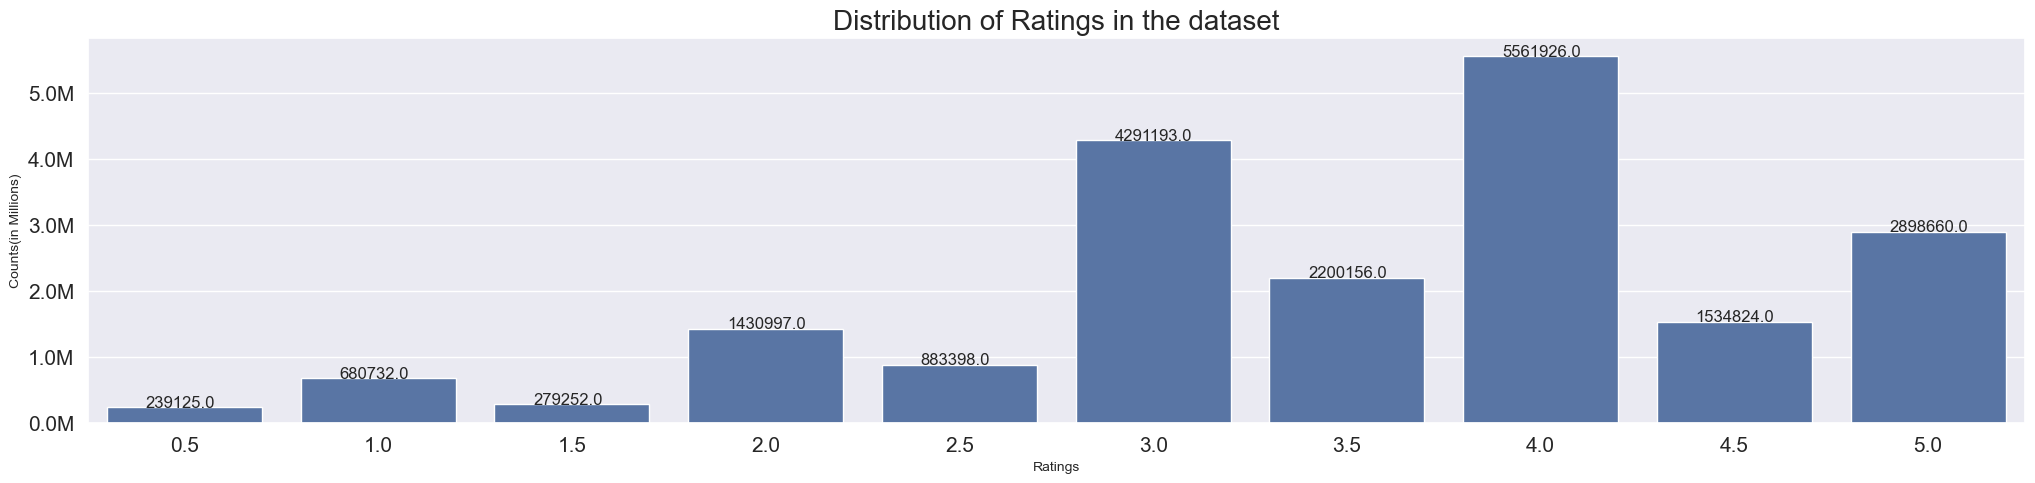

In [33]:
# Checking the feature "rating"
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

# Removed the 'data' argument and using 'x' instead
sns.countplot(x="rating", data=movie_ratings, ax=axes)
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in the dataset", fontsize = 20)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Counts(in Millions)", fontsize = 10)
plt.show()

Observations:

Les évaluations données par les utilisateurs aux films se situent entre 0,5 et 5.

Une grande proportion des films ont été évalués à 3, 3,5 ou 4 par les utilisateurs.

La distribution des évaluations semble légèrement biaisée à gauche, car une grande proportion des évaluations se trouve entre 3 et 5.

In [34]:
# Checking the feature "date"

print("The count of unique date in the dataset is : ", movie_ratings["date"].nunique())
print("The first rating was given on : ", movie_ratings["date"].min())
print("The latest rating was given on : ", movie_ratings["date"].max())
print("The top 5 date in the dataset are : \n", movie_ratings["date"].value_counts()[:5])

The count of unique date in the dataset is :  6911
The first rating was given on :  1995-01-09
The latest rating was given on :  2015-03-31
The top 5 date in the dataset are : 
 date
2000-11-20    91753
2005-03-22    76568
1999-12-11    65077
2008-10-29    55163
2000-11-21    54131
Name: count, dtype: int64


Observations:

Il y a environ 7 000 dates uniques sur lesquelles les évaluations ont été données par un utilisateur à un film.

La première évaluation a été donnée le 9 janvier 1995 et la dernière le 31 mars 2015.

Environ 91 000 évaluations ont été observées le 20 novembre 2000.

In [35]:
# Checking the feature "title"

movie_list = movie_ratings["title"].unique()
print("The count of unique title in the dataset is : ", movie_ratings["title"].nunique())
print("The top 5 title in the dataset are : \n", movie_ratings["title"].value_counts()[:5])

The count of unique title in the dataset is :  26729
The top 5 title in the dataset are : 
 title
Pulp Fiction (1994)                 67310
Forrest Gump (1994)                 66172
Shawshank Redemption, The (1994)    63366
Silence of the Lambs, The (1991)    63299
Jurassic Park (1993)                59715
Name: count, dtype: int64


Observations:  

Il y a plus de 26 000 titres de films uniques dans le jeu de données.

Pulp Fiction, Forrest Gump, Shawshank Redemption et Silence of the Lambs sont les 4 films les plus populaires en termes de nombre d'évaluations reçues, chacun ayant plus de 60 000 évaluations.

In [36]:
# Extract unique Genres along with their count

unique_genres = {}

def ExtractGenres(x):
    for g in x.split("|"):
        if g not in unique_genres.keys():
            unique_genres[g] = 1
        else:
            unique_genres[g] = unique_genres[g] + 1

movie_ratings["genres"].apply(ExtractGenres)
print("Genres Extracted from the dataset.")

Genres Extracted from the dataset.


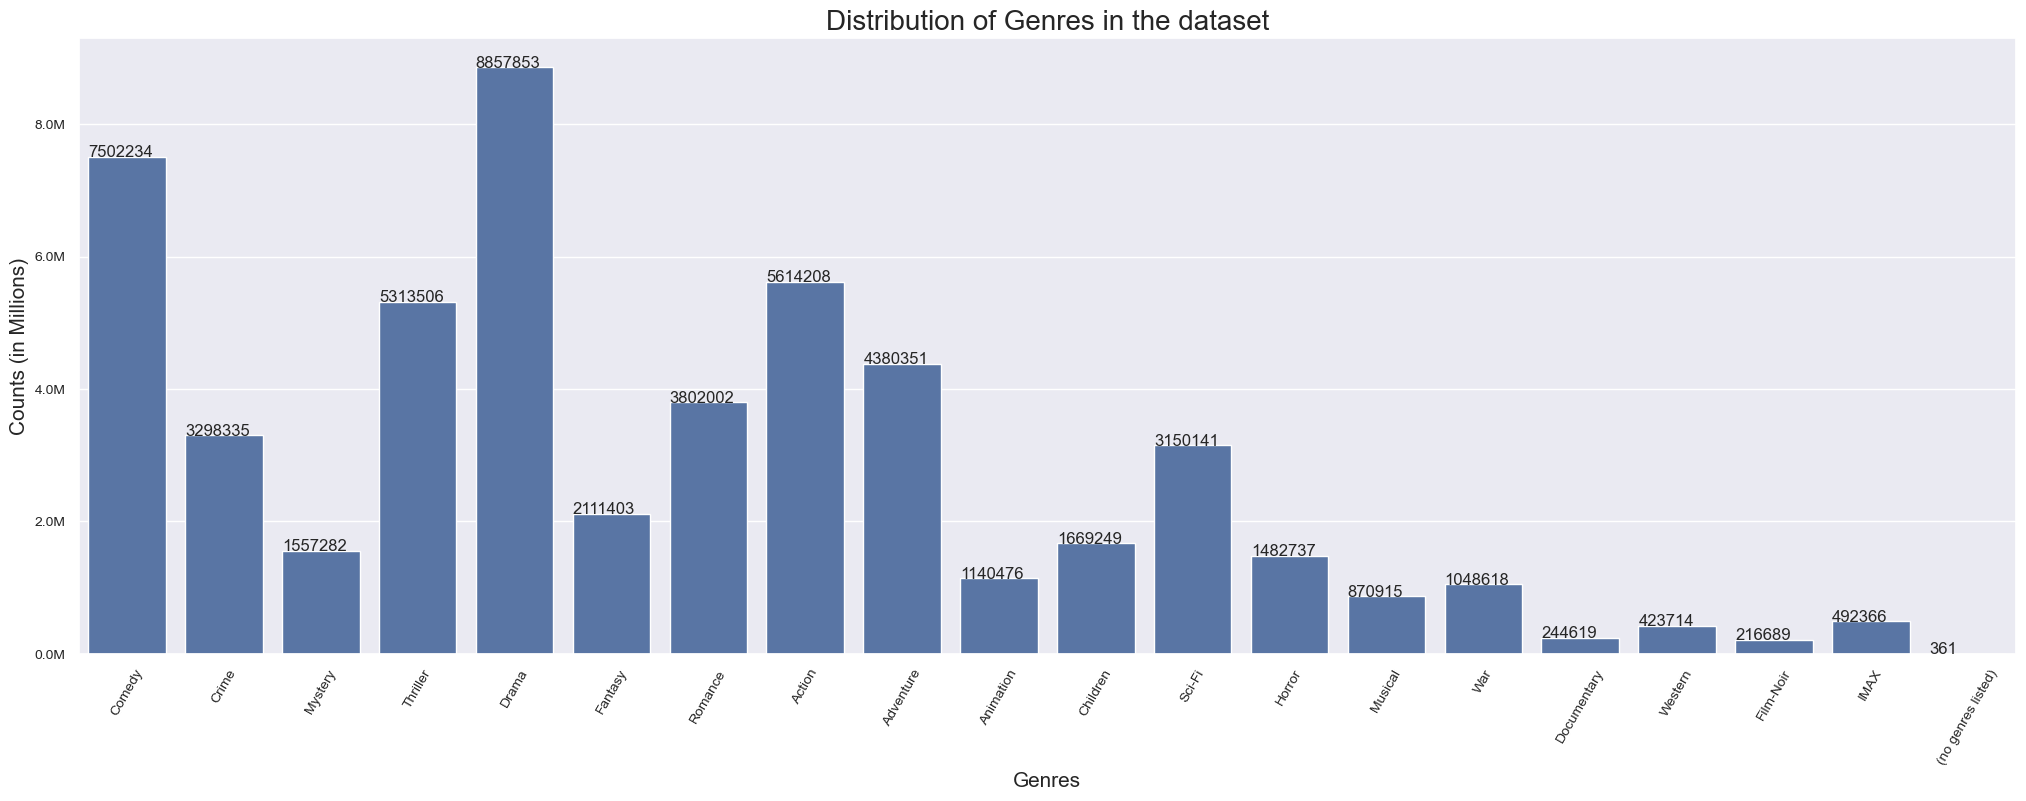

In [37]:
# Visualizing the feature "Genres"

genres_df = pd.DataFrame(list(unique_genres.items()))
genres_df.columns = ["Genre", "Count"]

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 8), sharey=True)

sns.barplot(y="Count", x="Genre", data=genres_df, ax=axes)
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Genres in the dataset", fontsize = 20)
plt.xlabel("Genres", fontsize = 15)
plt.xticks(rotation=60, fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts (in Millions)", fontsize = 15)
plt.show()

Observations:

Il y a 19 genres différents de films, bien qu'il y en ait quelques-uns dont le genre n'ait pas été mentionné.

Drama, Comedy, Action et Thriller sont les 4 genres les plus présents dans le jeu de données.

In [38]:
movie_ratings.head()

,userId,movieId,rating,date,title,genres
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,131160,21,3.0,1995-01-09,Get Shorty (1995),Comedy|Crime|Thriller
4,85252,7,5.0,1996-01-29,Sabrina (1995),Comedy|Romance


#### **3.2.2 Train & test Splitting**

Séparation des données en ensembles d'entraînement et de test avant de procéder à l'analyse exploratoire des données (EDA) et à l'ingénierie des caractéristiques (Feature Engineering).

In [39]:
import os
import pandas as pd

save_path = "/content"
os.makedirs(save_path, exist_ok=True)

# Fonction pour charger ou créer les données
def load_or_create_data(data_type, data_range):
    filename = os.path.join(save_path, f"{data_type}Data.pkl")

    if not os.path.isfile(filename):
        print(f"Création des données {data_type} et sauvegarde...")
        data = movie_ratings.iloc[data_range].copy()
        data.to_pickle(filename)
        loaded_data = pd.read_pickle(filename)
    else:
        print(f"Chargement des données {data_type}...")
        loaded_data = pd.read_pickle(filename)

    loaded_data.reset_index(drop=True, inplace=True)
    return loaded_data

# Charger ou créer les ensembles
Train_Data = load_or_create_data("Train", slice(None, int(movie_ratings.shape[0] * 0.80)))
Test_Data = load_or_create_data("Test", slice(int(movie_ratings.shape[0] * 0.80), None))

# Vérification
print("\nAperçu des données d'entraînement:")
print(Train_Data.head())

print("\nAperçu des données de test:")
print(Test_Data.head())

print(f"\nTaille des ensembles:")
print(f"- Entraînement: {len(Train_Data)} lignes ({len(Train_Data)/len(movie_ratings)*100:.1f}%)")
print(f"- Test: {len(Test_Data)} lignes ({len(Test_Data)/len(movie_ratings)*100:.1f}%)")

Création des données Train et sauvegarde...
Création des données Test et sauvegarde...

Aperçu des données d'entraînement:
   userId  movieId  rating        date  \
0  131160     1058     3.0  1995-01-09   
1  131160       47     5.0  1995-01-09   
2   28507     1154     4.0  1995-01-09   
3  131160       21     3.0  1995-01-09   
4   85252        7     5.0  1996-01-29   

                                               title                 genres  
0                        Fish Called Wanda, A (1988)           Comedy|Crime  
1                        Seven (a.k.a. Se7en) (1995)       Mystery|Thriller  
2  Double Life of Veronique, The (Double Vie de V...  Drama|Fantasy|Romance  
3                                  Get Shorty (1995)  Comedy|Crime|Thriller  
4                                     Sabrina (1995)         Comedy|Romance  

Aperçu des données de test:
   userId  movieId  rating        date                     title  \
0   80910     5784     1.5  2009-10-20    Treasure Planet (

In [40]:
Train_Data.head()

,userId,movieId,rating,date,title,genres
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,131160,21,3.0,1995-01-09,Get Shorty (1995),Comedy|Crime|Thriller
4,85252,7,5.0,1996-01-29,Sabrina (1995),Comedy|Romance


In [41]:
# Creating list of unique movies from Train Set

movie_list_in_training = Train_Data.drop_duplicates(subset=["title"], keep="first")[["movieId", "title", "genres"]]
movie_list_in_training = movie_list_in_training.reset_index(drop=True)
movie_list_in_training.head()

,movieId,title,genres
0,1058,"Fish Called Wanda, A (1988)",Comedy|Crime
1,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,1154,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,21,Get Shorty (1995),Comedy|Crime|Thriller
4,7,Sabrina (1995),Comedy|Romance


In [42]:
# Checking the basic statistics for the training data

print("Total Train Data..")
print("Total number of movie ratings in train data : ", str(Train_Data.shape[0]))
print("Number of unique users in train data : ", str(len(np.unique(Train_Data["userId"]))))
print("Number of unique movies in train data : ", str(len(np.unique(Train_Data["movieId"]))))

Total Train Data..
Total number of movie ratings in train data :  16000210
Number of unique users in train data :  112466
Number of unique movies in train data :  12387


#### **3.2.3 Bi-variate Analysis**

Analyse de plusieurs caractéristiques ensemble afin de découvrir des relations, des corrélations et des motifs.

---

#####**1. Analyzing the Distribution of Ratings**

In [43]:
# Checking basic statistics for "rating"

print("The basic statistics for the feature is : \n", Train_Data["rating"].describe())

The basic statistics for the feature is : 
 count    1.600021e+07
mean     3.512613e+00
std      1.059931e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


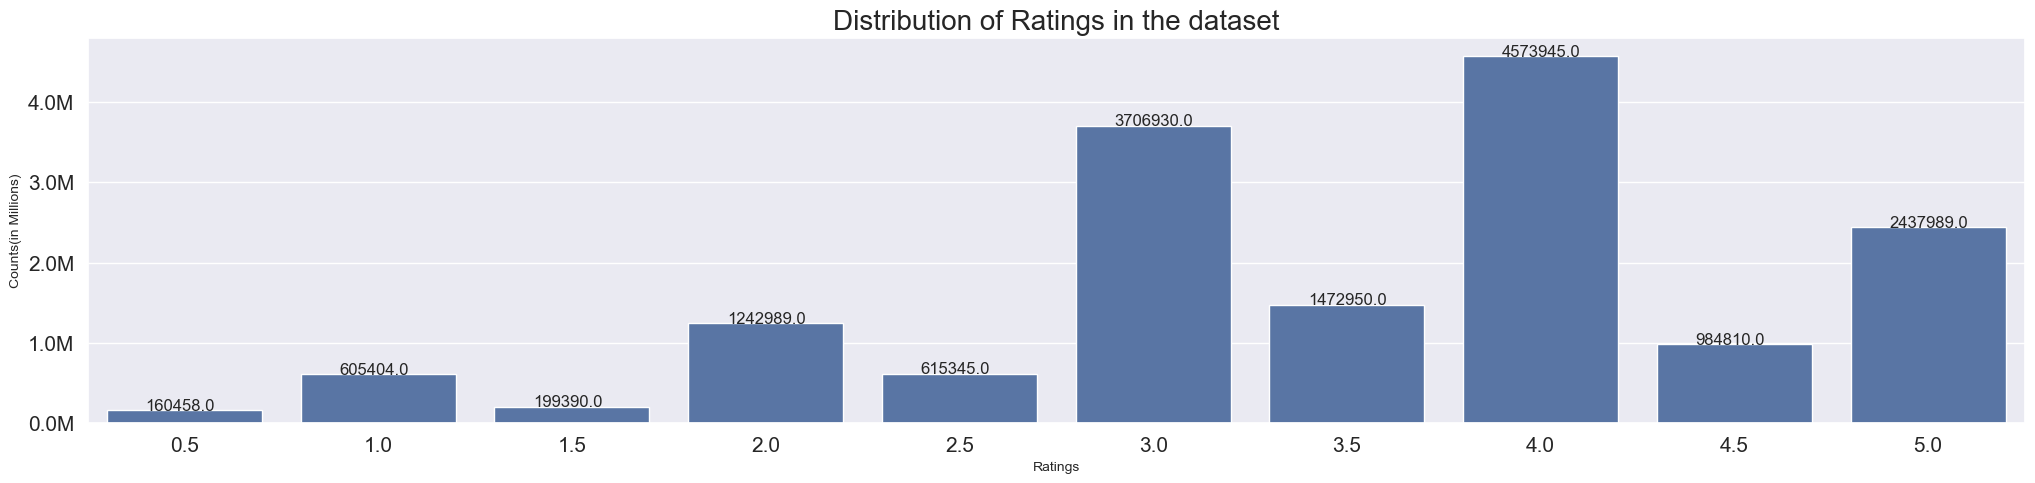

In [44]:
# Visualizing the "rating" for the train set

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

# Removed the 'x' argument and keeping only 'data'
sns.countplot(data=Train_Data, x="rating", ax=axes)
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in the dataset", fontsize = 20)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Counts(in Millions)", fontsize = 10)
plt.show()

Observations:

La distribution des évaluations semble être similaire à celle observée précédemment.

La valeur moyenne et la médiane sont très proches, autour de 3,5.

---

#####**2. Analyzing the number of ratings with date.**

In [45]:
# Extracting the day of week from the date when rating was provided

Train_Data["date"] = pd.to_datetime(Train_Data["date"], errors='coerce')
Train_Data["DayOfWeek"] = Train_Data["date"].dt.strftime('%A')
Train_Data["Weekday"] = Train_Data["date"].apply(lambda x : 1 if x.dayofweek > 5 else 0)

In [46]:
# Converting the number into 'Ks.

def ChangingLabelsInK(number):
    return str(int(number/10**3)) + "K"

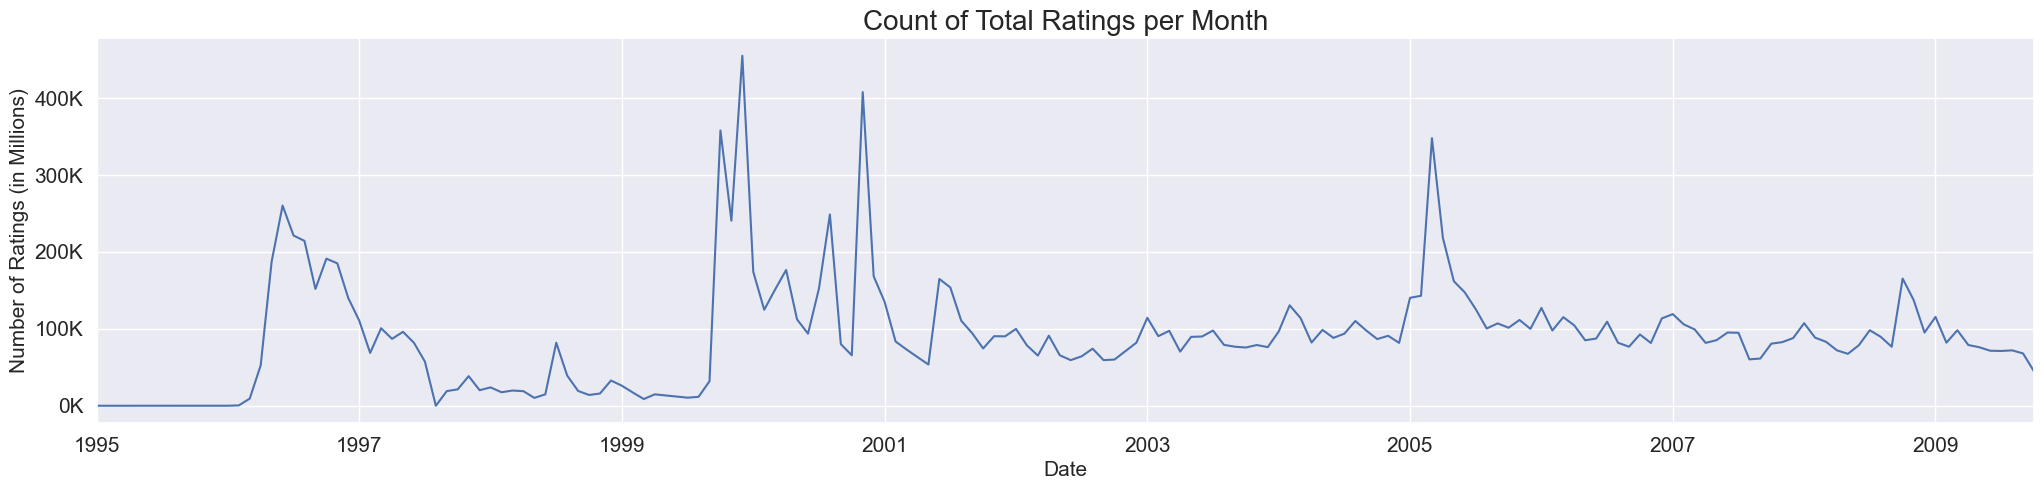

In [47]:
# Visualizing the count of total ratings made per month

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)
axes = Train_Data.resample("m", on = "date")["rating"].count().plot()

axes.set_yticklabels([ChangingLabelsInK(num) for num in axes.get_yticks()])
axes.set_title("Count of Total Ratings per Month", fontsize = 20)
axes.set_xlabel("Date", fontsize = 15)
axes.set_ylabel("Number of Ratings (in Millions)", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.show()

Observations:

Le nombre d'évaluations par mois était très élevé pendant certains mois entre 1996 et 1998.

De même, après les années 2000, il y a quelques mois avec un nombre d'évaluations exceptionnellement élevé.

Le nombre d'évaluations reste stable entre 2001 et 2010, avec un pic durant certains mois de 2006.

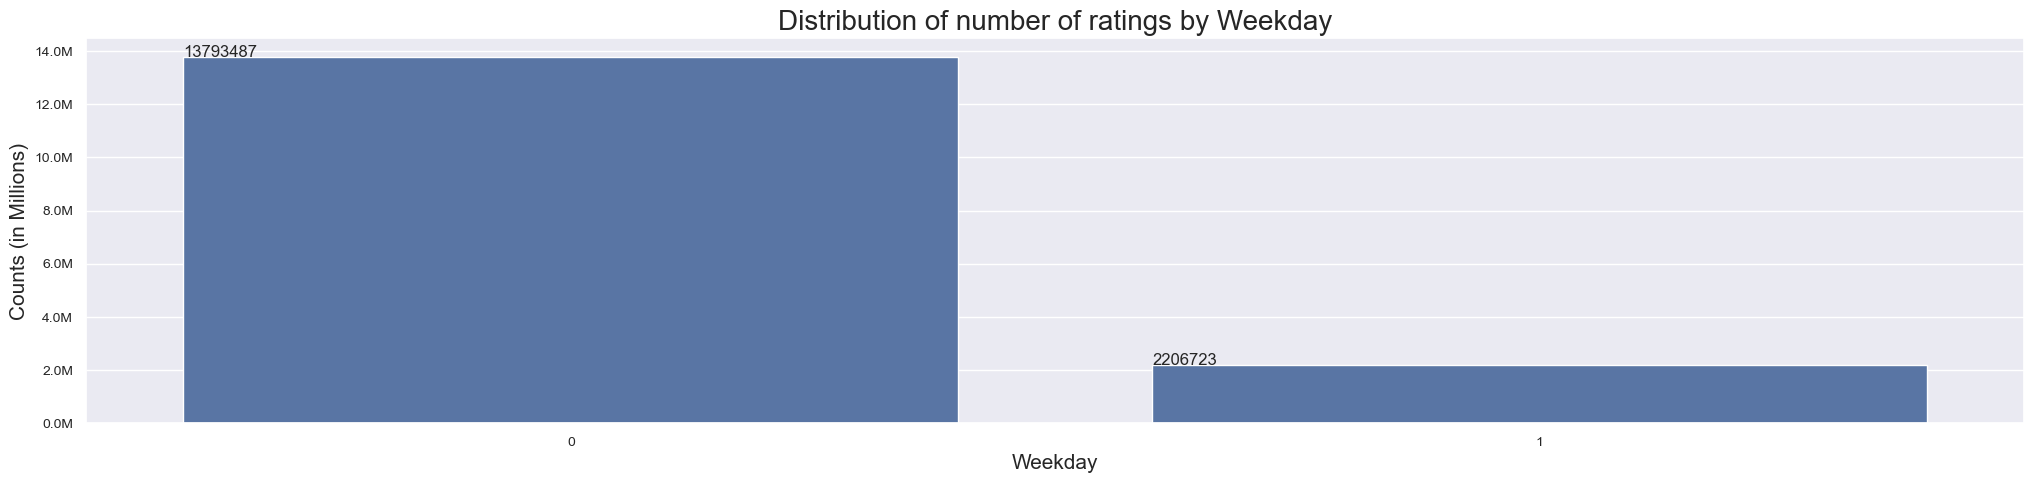

In [48]:
# Visualizing the count of ratings by weekday

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="Weekday", y="rating" , data=Train_Data.groupby(by=["Weekday"], as_index=False)["rating"].count(), ax=axes)
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Distribution of number of ratings by Weekday", fontsize = 20)
plt.xlabel("Weekday", fontsize = 15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts (in Millions)", fontsize = 15)
plt.show()

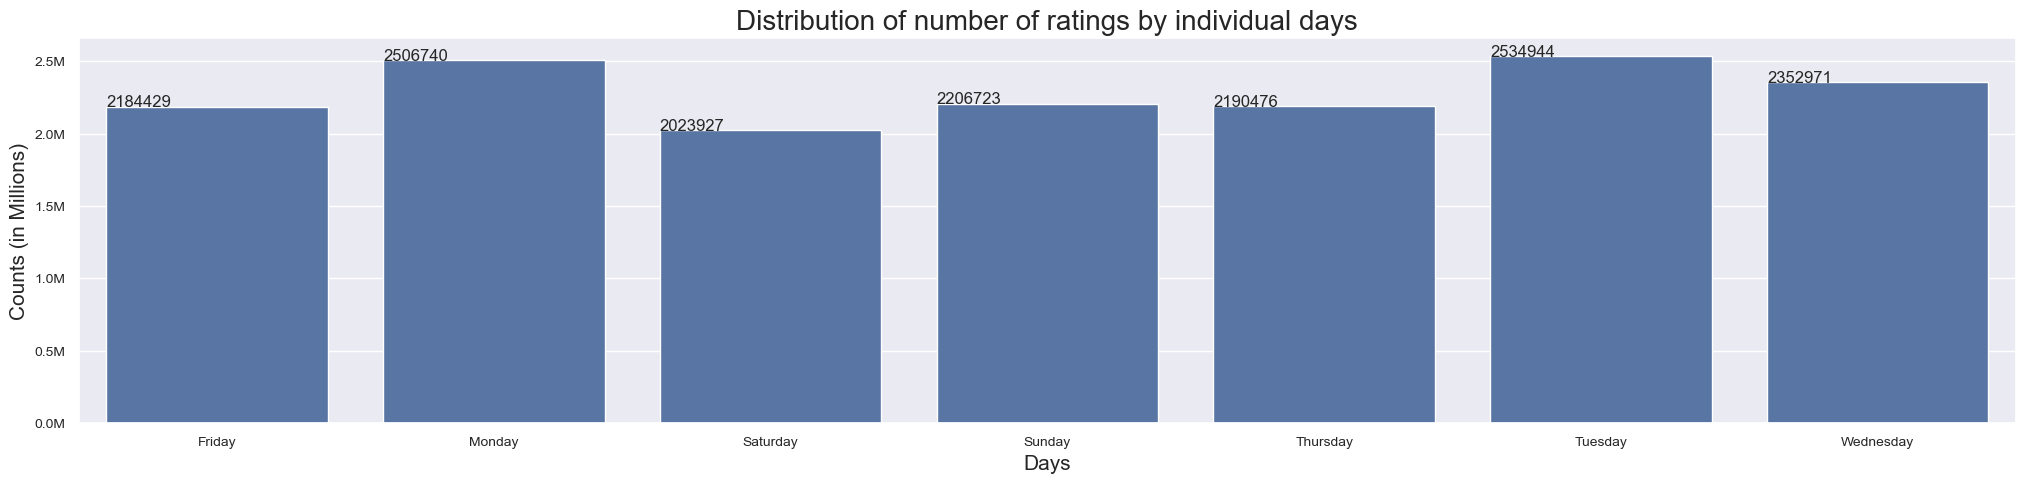

In [49]:
# Visualizing the count of ratings by individual days of the week

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="DayOfWeek", y="rating" , data=Train_Data.groupby(by=["DayOfWeek"], as_index=False)["rating"].count(), ax=axes)
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Distribution of number of ratings by individual days", fontsize = 20)
plt.xlabel("Days", fontsize = 15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts (in Millions)", fontsize = 15)
plt.show()

Observations:

Le nombre d'évaluations ne varie pas beaucoup en fonction des jours de la semaine.

Lundi et Mardi ont clairement un nombre d'évaluations plus élevé que les autres jours.

Le nombre d'évaluations le week-end est clairement beaucoup plus faible que pendant les jours de semaine.

---

#####**3. Analyzing the average ratings by date.**

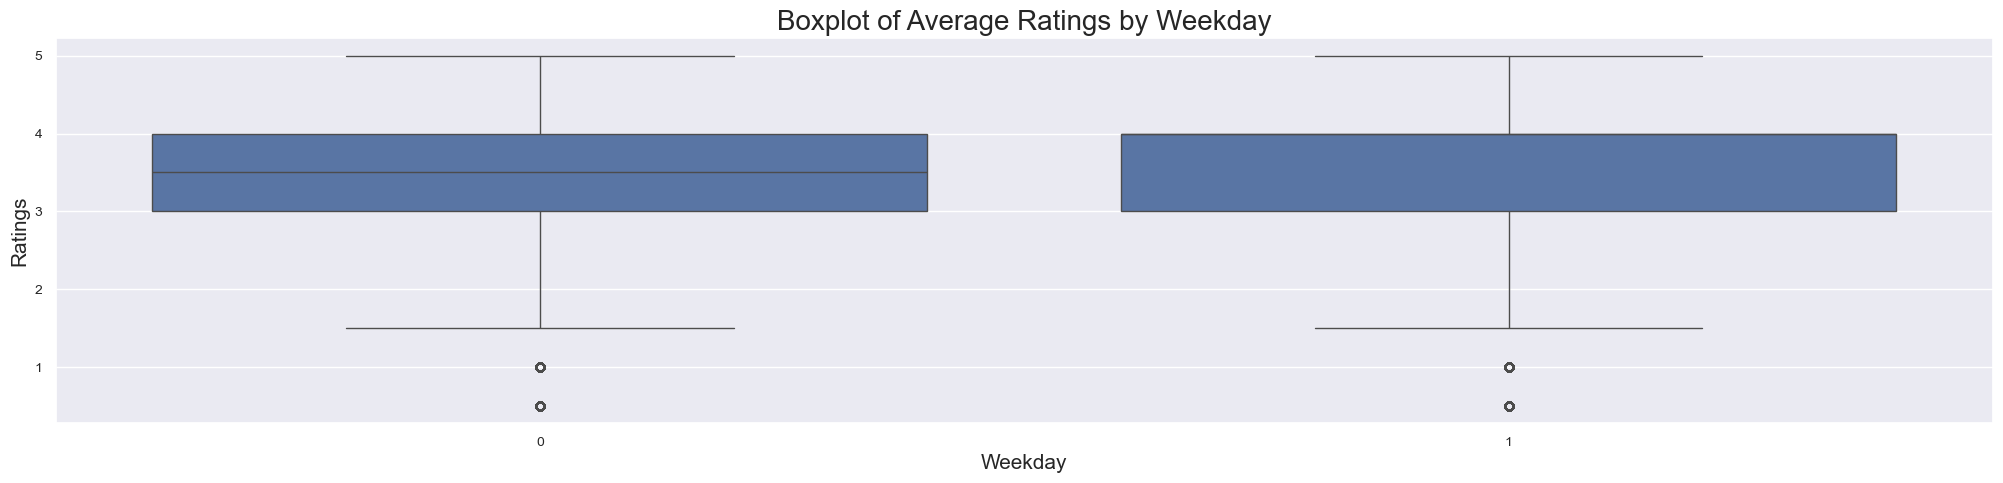

In [50]:
# Visualizing the average ratings by weekday

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.boxplot(x="Weekday", y="rating" , data=Train_Data, ax=axes)

plt.tick_params(labelsize = 15)
plt.title("Boxplot of Average Ratings by Weekday", fontsize = 20)
plt.xlabel("Weekday", fontsize = 15)
plt.xticks(fontsize=10)
plt.ylabel("Ratings", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

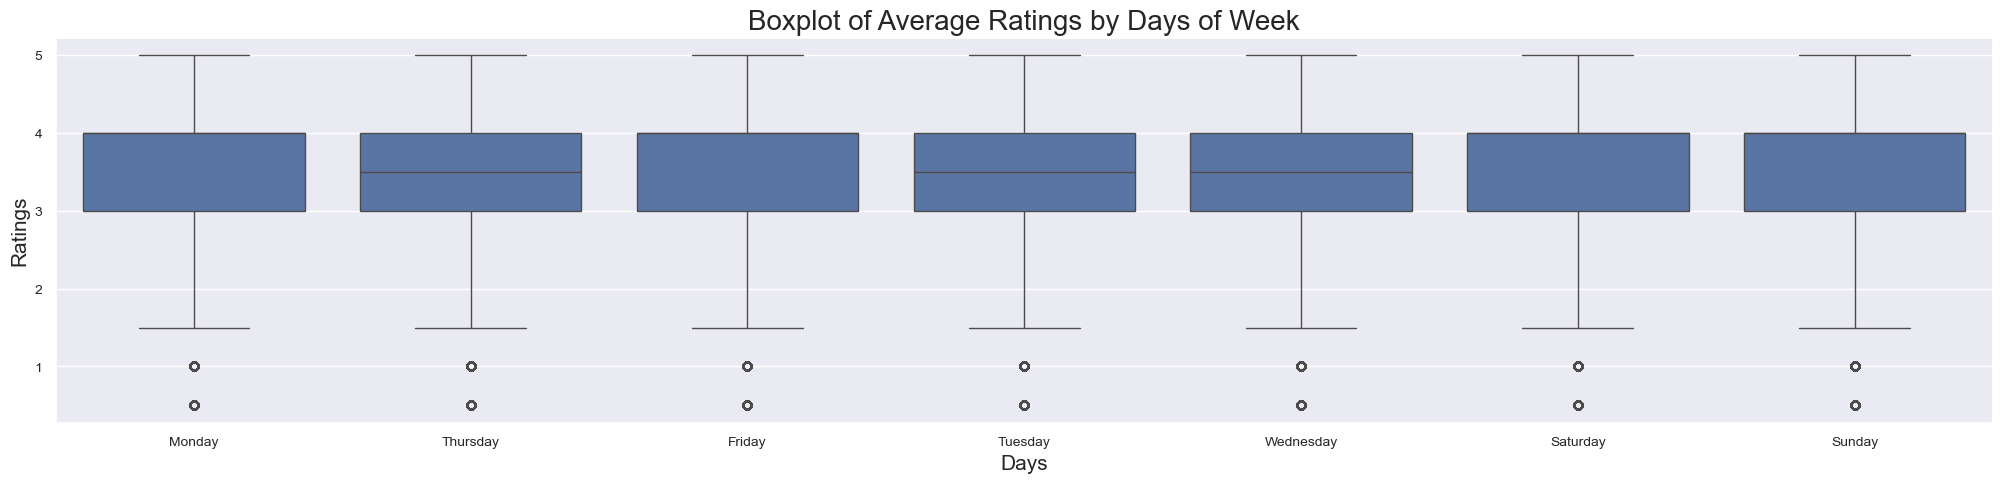

In [51]:
# Visualizing the average ratings by individual Days of the Week

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.boxplot(x="DayOfWeek", y="rating", data=Train_Data, ax=axes)

plt.tick_params(labelsize = 15)
plt.title("Boxplot of Average Ratings by Days of Week", fontsize = 20)
plt.xlabel("Days", fontsize = 15)
plt.xticks(fontsize=10)
plt.ylabel("Ratings", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

Observations:

La moyenne des évaluations données par les utilisateurs ne semble pas différer entre les jours de semaine et le week-end.

Même lorsque nous traçons les évaluations moyennes par jour individuel, elles semblent similaires pour tous les jours de la semaine..

---

#####**4. Analyzing the Ratings given by Users.**

In [52]:
# Calculating the number of ratings given by individual users

no_of_rated_movies_per_user = Train_Data.groupby(by=["userId"], as_index=False)["rating"].count().sort_values(by="rating", ascending=False)
no_of_rated_movies_per_user.reset_index(drop=True, inplace=True)

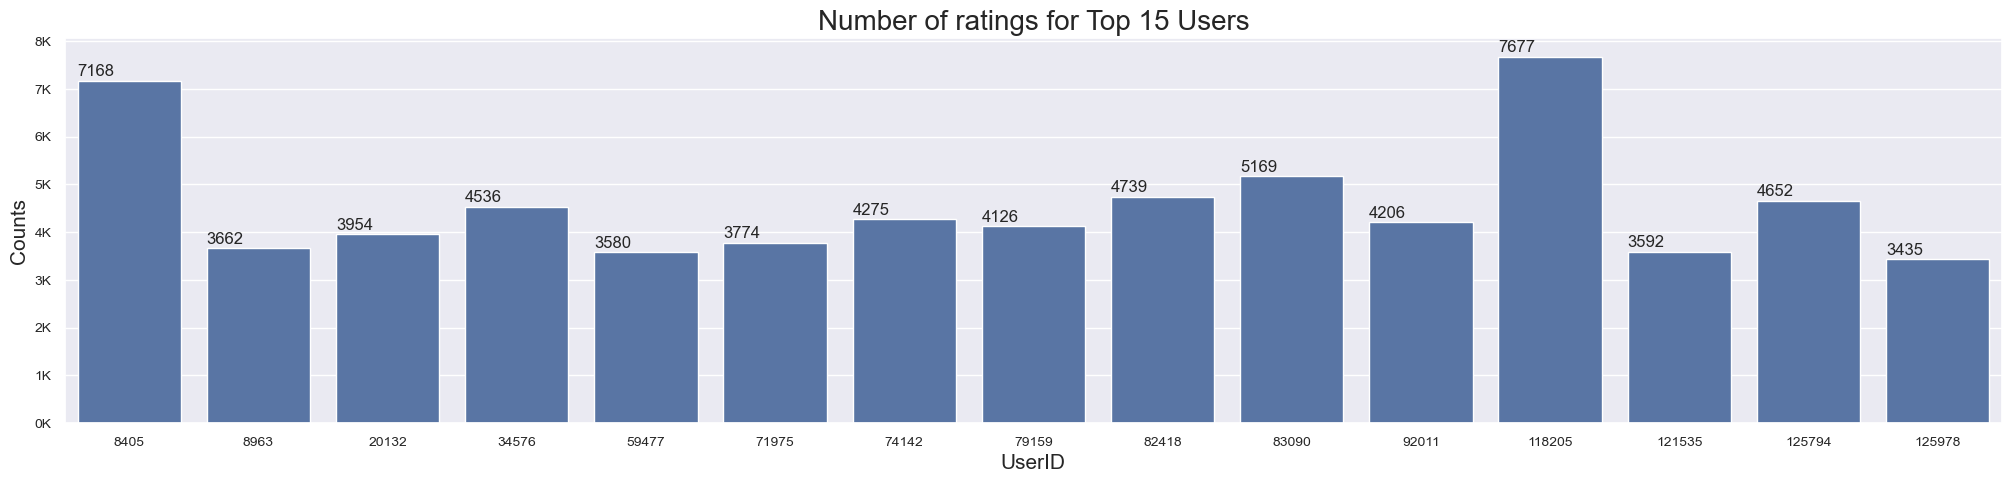

In [53]:
# Visualizing the count of ratings by individual users

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="userId", y="rating" , data=no_of_rated_movies_per_user[:15], ax=axes)
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

axes.set_yticklabels([ChangingLabelsInK(num) for num in axes.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Number of ratings for Top 15 Users", fontsize = 20)
plt.xlabel("UserID", fontsize = 15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts", fontsize = 15)
plt.show()

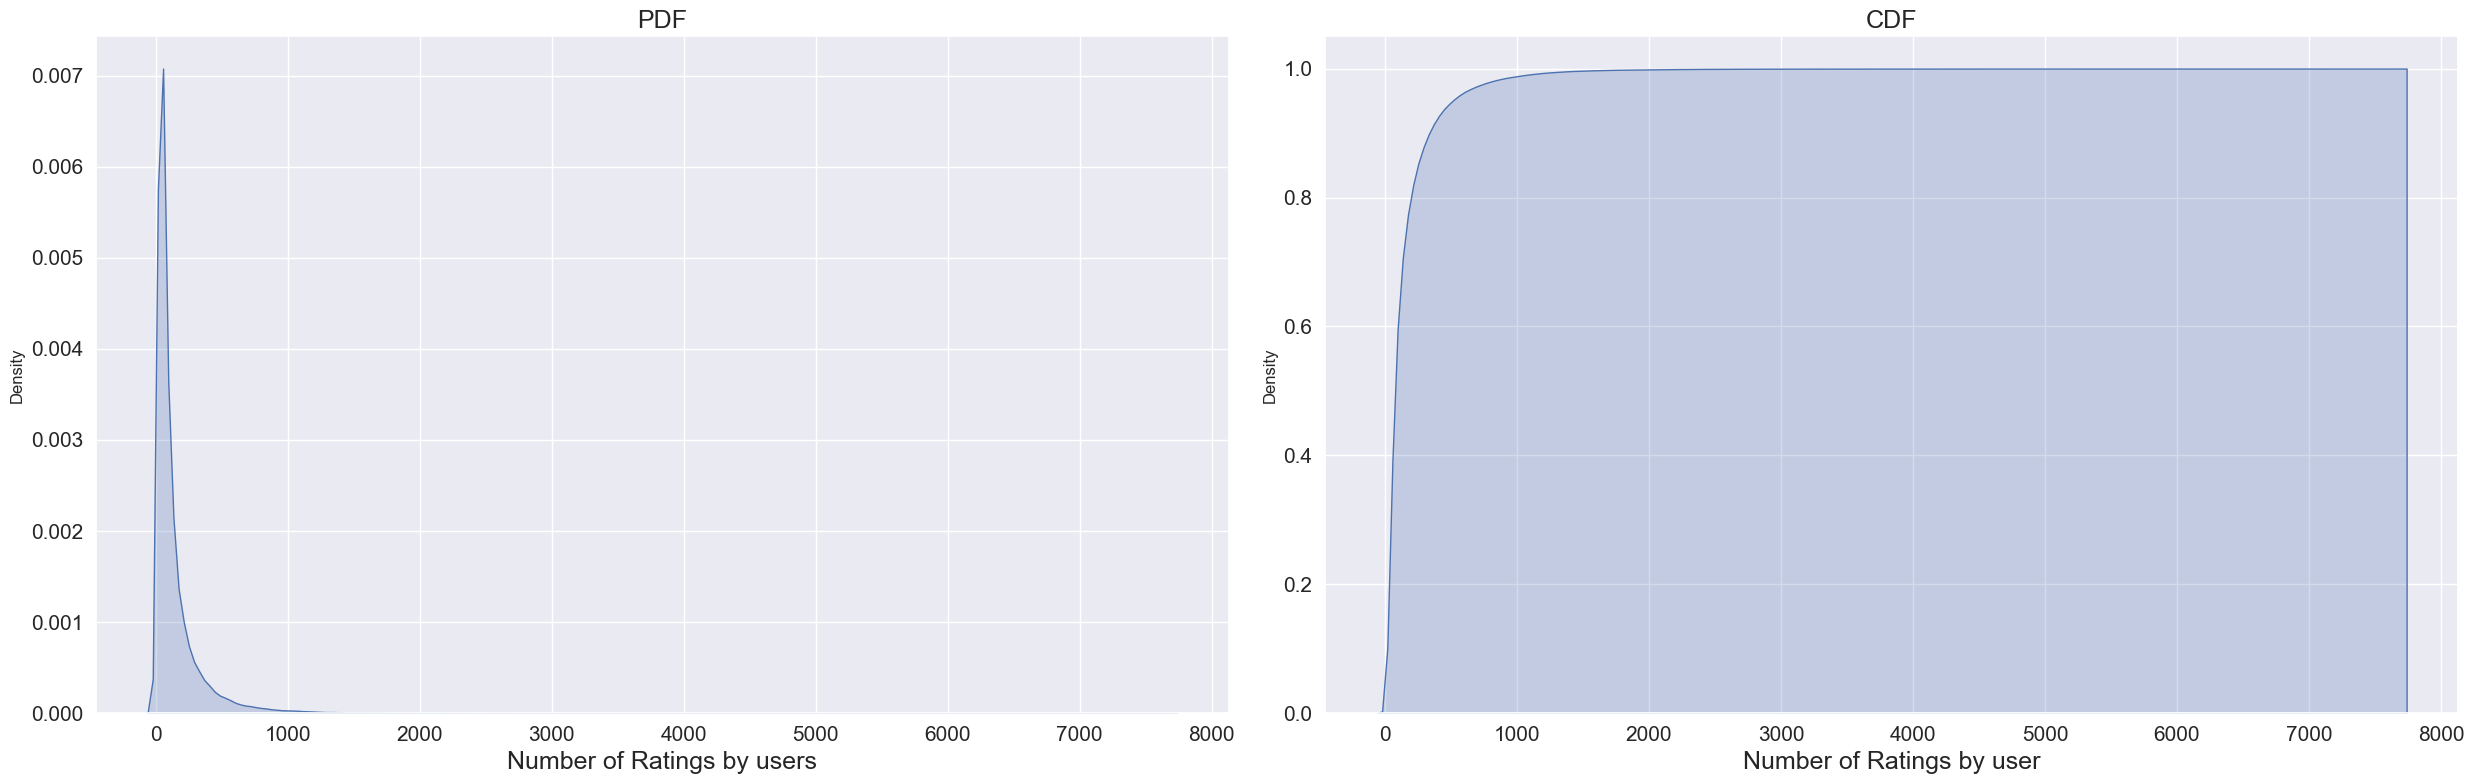

In [54]:
# Visualizing the count of ratings by individual users

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 8))

sns.kdeplot(no_of_rated_movies_per_user["rating"], shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings by users", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(no_of_rated_movies_per_user["rating"], shade = True, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

**PDF (Distribution des notes) :**

Pic marqué autour des faibles valeurs (0-1000 évaluations), indiquant que la majorité des utilisateurs ont évalué peu de films.

Queue longue : Quelques utilisateurs très actifs ont évalué jusqu'à 8000 films (extrême droite du graphique).

**CDF (Distribution cumulative) :**

Courbe raide au début : Environ 90% des utilisateurs ont évalué moins de 1000 films.

Saturation après 2000 évaluations : Seule une infime fraction des utilisateurs dépasse ce seuil.

In [55]:
# Checking the basic statistics for the number of ratings per user

print("Information about no. of ratings by users : \n", no_of_rated_movies_per_user["rating"].describe())

Information about no. of ratings by users : 
 count    112466.000000
mean        142.267085
std         214.808118
min           1.000000
25%          35.000000
50%          69.000000
75%         155.000000
max        7677.000000
Name: rating, dtype: float64


In [56]:
quantiles = no_of_rated_movies_per_user["rating"].quantile(np.arange(0.9, 1.01,0.01))
qvalue = np.arange(0.9, 1.01,0.01)
for ctr in qvalue:
    print("The {}th quantile value is : {}".format(int(ctr*100), quantiles[ctr]))

The 90th quantile value is : 333.0
The 91th quantile value is : 358.0
The 92th quantile value is : 386.0
The 93th quantile value is : 418.0
The 94th quantile value is : 459.0
The 95th quantile value is : 510.0
The 96th quantile value is : 573.0
The 97th quantile value is : 664.0
The 98th quantile value is : 804.7000000000116
The 99th quantile value is : 1060.3500000000058
The 100th quantile value is : 7677.0


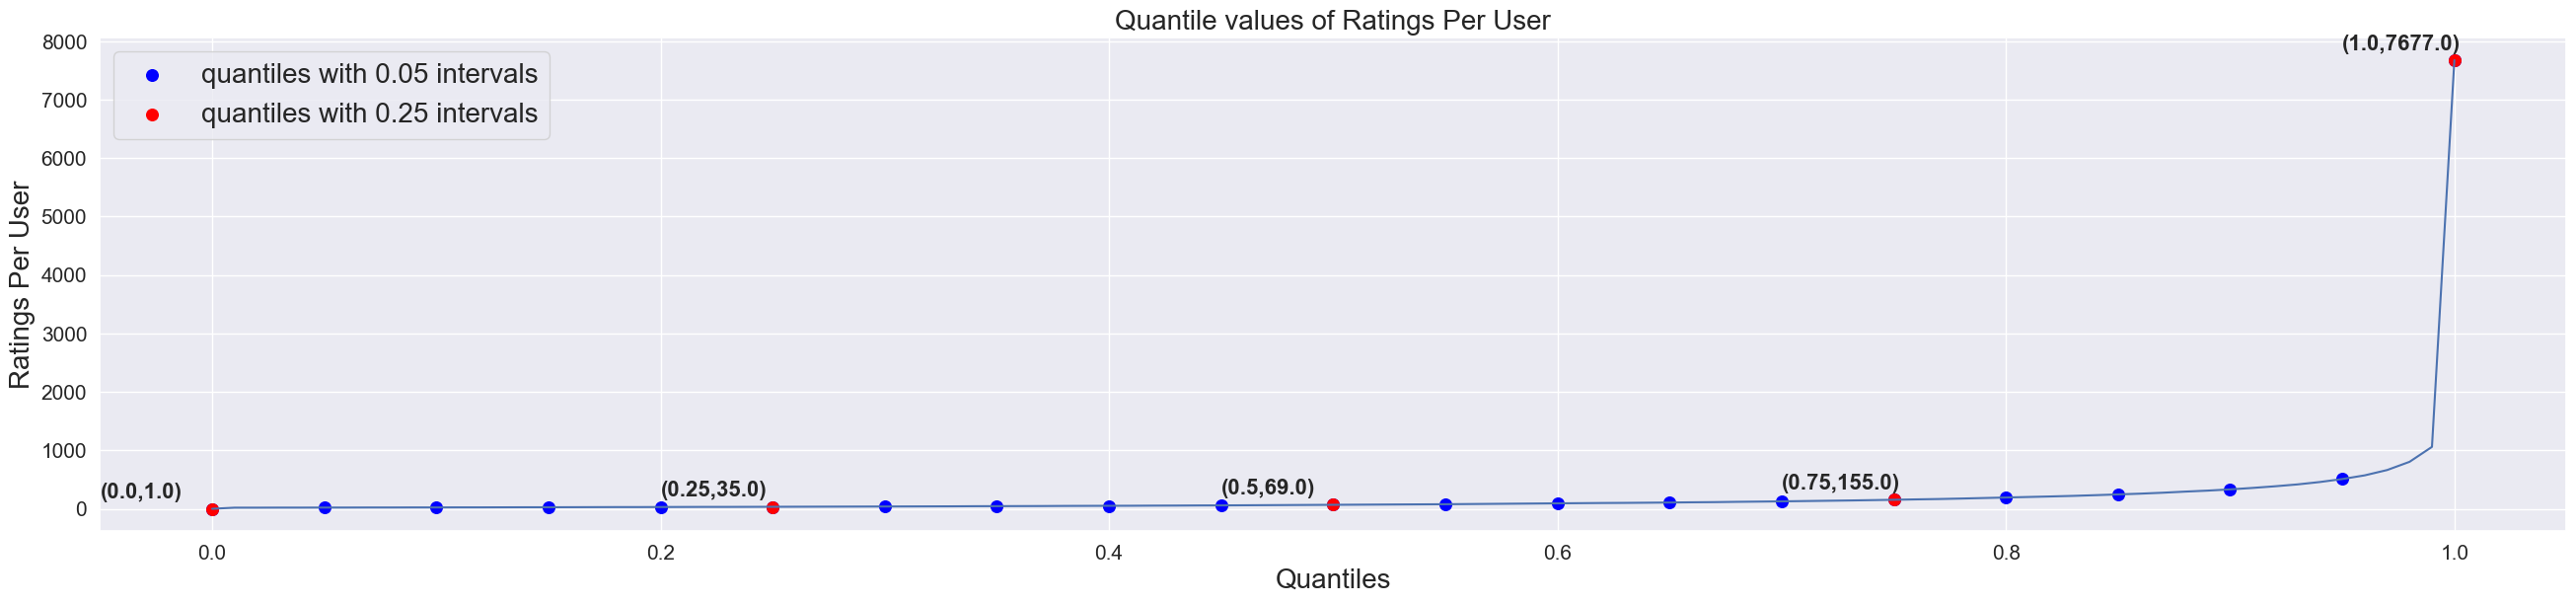

In [57]:
# Plotting the quantile values

quantiles = no_of_rated_movies_per_user["rating"].quantile(np.arange(0, 1.01,0.01))

fig = plt.figure(figsize = (25, 5))

axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Quantile values of Ratings Per User", fontsize = 20)
axes.set_xlabel("Quantiles", fontsize = 20)
axes.set_ylabel("Ratings Per User", fontsize = 20)
axes.plot(quantiles)

plt.scatter(x = quantiles.index[::5], y = quantiles.values[::5], c = "blue", s = 70, label="quantiles with 0.05 intervals")
plt.scatter(x = quantiles.index[::25], y = quantiles.values[::25], c = "red", s = 70, label="quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize = 20)

# Changed 's' to 'text' in plt.annotate()
for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
    plt.annotate(text='({},{})'.format(x, y), xy = (x, y), fontweight='bold', fontsize = 16, xytext=(x-0.05, y+180))

axes.tick_params(labelsize = 15)

Observations:

Les 10 premiers utilisateurs ont tendance à avoir évalué plus de 4 000 fois, ce qui semble être un comportement un peu extrême.

L'userId 118205 a évalué plus de 7 000 fois, ce qui semble surprenant.

D'après le graphique KDE, il est clairement évident que le nombre d'évaluations est fortement biaisé à droite, et que la plupart des évaluations des utilisateurs se situent entre 0 et 1 000.

De même, le graphique CDF ci-dessus montre qu'environ 99 % des utilisateurs donnent très peu d'évaluations.

Le nombre moyen d'évaluations qu'un utilisateur donne est de 142, tandis que la médiane est de 69.

Le nombre de films commence à augmenter de manière significative à partir du 90e percentile.

In [58]:
# Calculating average ratings given by individual users

avg_ratings_per_user = Train_Data.groupby(by = ["userId"], as_index=False)["rating"].mean()
avg_ratings_per_user = avg_ratings_per_user.reset_index(drop=True)
avg_ratings_per_user = avg_ratings_per_user.merge(no_of_rated_movies_per_user[["userId", "rating"]], how="left", on="userId")
avg_ratings_per_user.rename(columns={"rating_x":"avg_rating", "rating_y": "num_of_rating"}, inplace=True)
avg_ratings_per_user = avg_ratings_per_user.sort_values("num_of_rating", ascending=False)

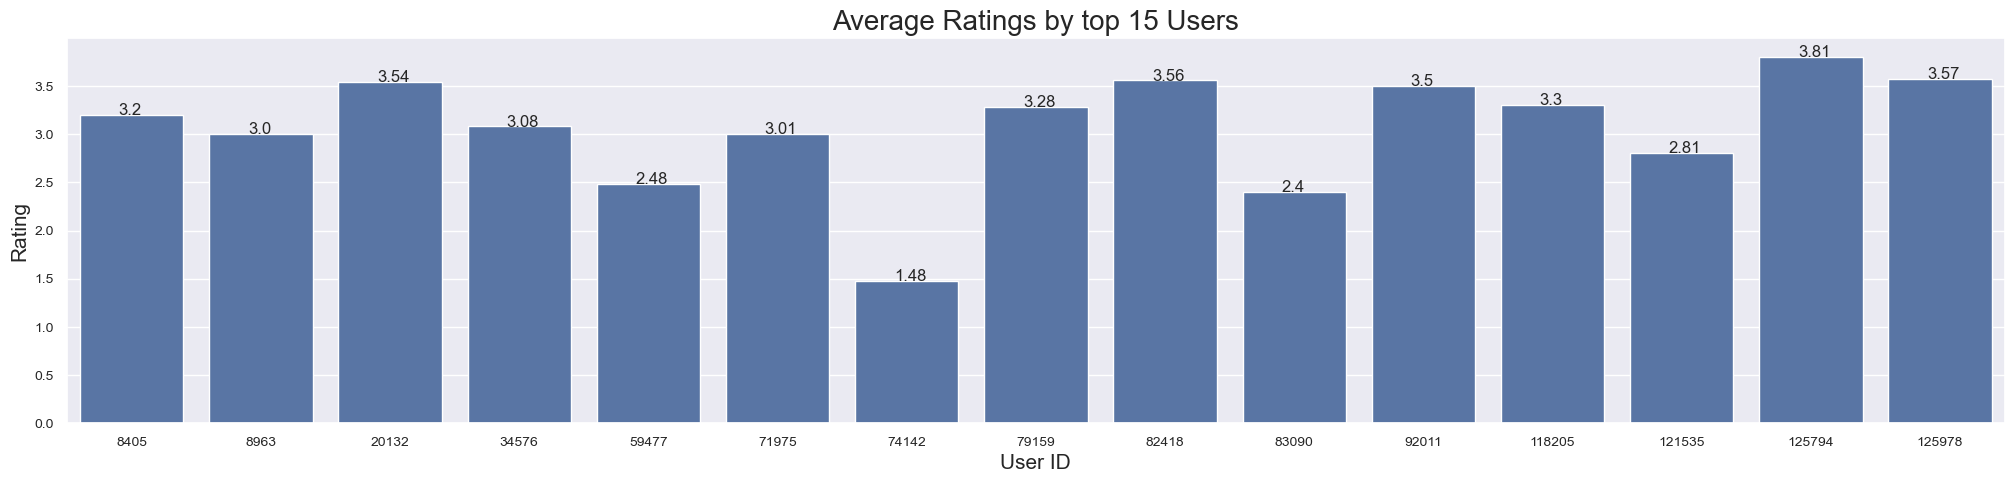

In [59]:
# Visualizing the average ratings by individual Days of the Week

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="userId", y="avg_rating", data=avg_ratings_per_user[:15], ax=axes)

for p in axes.patches:
    axes.annotate('{}'.format(round(p.get_height(), 2)), (p.get_x()+0.3, p.get_height()))

plt.tick_params(labelsize = 15)
plt.title("Average Ratings by top 15 Users", fontsize = 20)
plt.xlabel("User ID", fontsize = 15)
plt.xticks(fontsize=10)
plt.ylabel("Rating", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

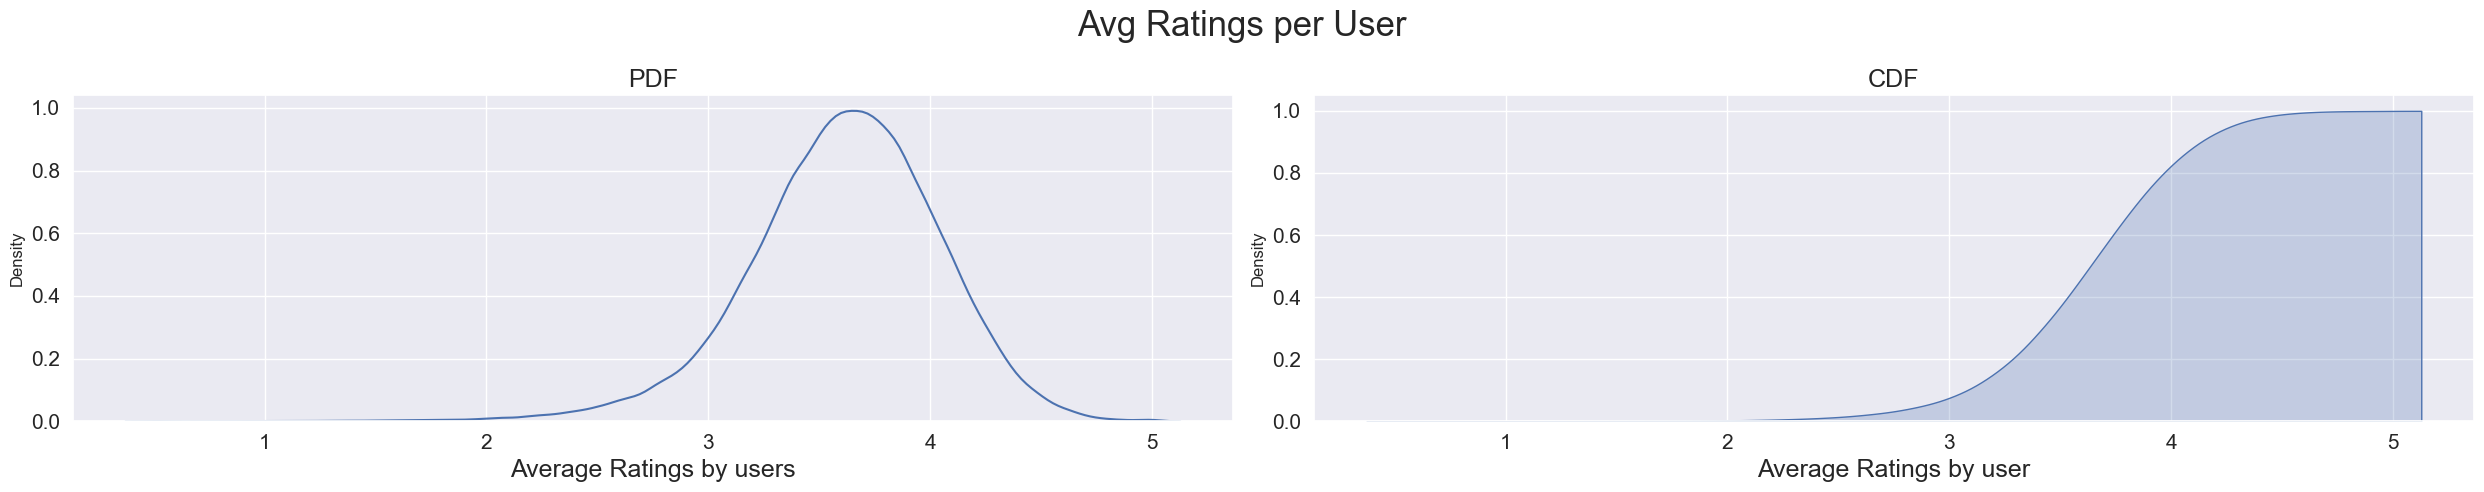

In [60]:
# Plotting the PDF and CDF for Avg. rating by Users

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 5))
fig.suptitle("Avg Ratings per User", fontsize=25)

sns.distplot(avg_ratings_per_user["avg_rating"], hist = False, ax = axes[0], label = "PDF")
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Average Ratings by users", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(avg_ratings_per_user["avg_rating"], cumulative = True, ax = axes[1], shade=True, label = "CDF")
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Average Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

Observations:

L'User ID 125794 a la moyenne d'évaluation la plus élevée avec 3,81.

Le pdf des évaluations moyennes données par un utilisateur semble légèrement biaisé à gauche, la plupart des valeurs étant centrées autour de 3,5 à 4.

Le cdf montre également que les évaluations moyennes sont les plus fréquentes entre 3 et 5.

---

#####**5. Analyzing the Ratings given to the Movies.**

In [61]:
# Calculating count of ratings received for movies

no_of_ratings_per_movie = Train_Data.groupby(by = ["movieId", "title"], as_index=False)["rating"].count().sort_values(by=["rating"], ascending = False)
no_of_ratings_per_movie = no_of_ratings_per_movie.reset_index(drop=True)

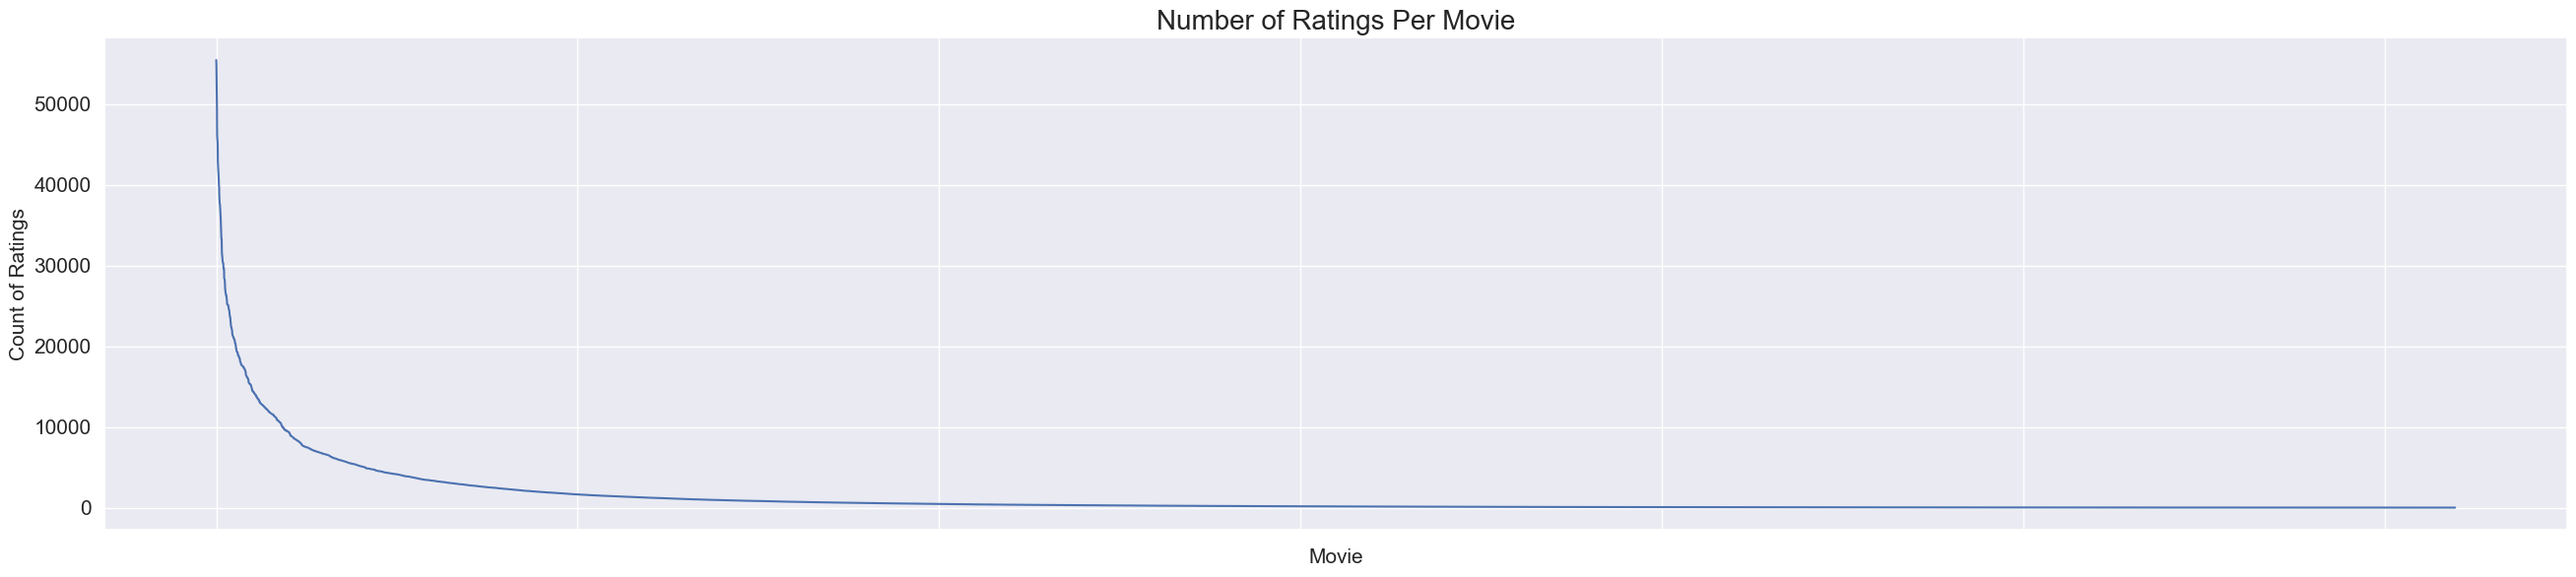

In [62]:
# Visualizing the number of ratings for the movies

sns.set(style="darkgrid")

fig = plt.figure(figsize = (25, 5))
axes = fig.add_axes([0.1, 0.1, 1, 1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 15)
plt.ylabel("Count of Ratings", fontsize = 15)

plt.plot(no_of_ratings_per_movie["rating"].values)

plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

Observations:

Il est assez clair qu'il existe certains films qui sont très populaires et ont été évalués par de nombreux utilisateurs, contrairement à d'autres films qui ont été évalués par moins de personnes, ce qui a causé une distorsion du graphique



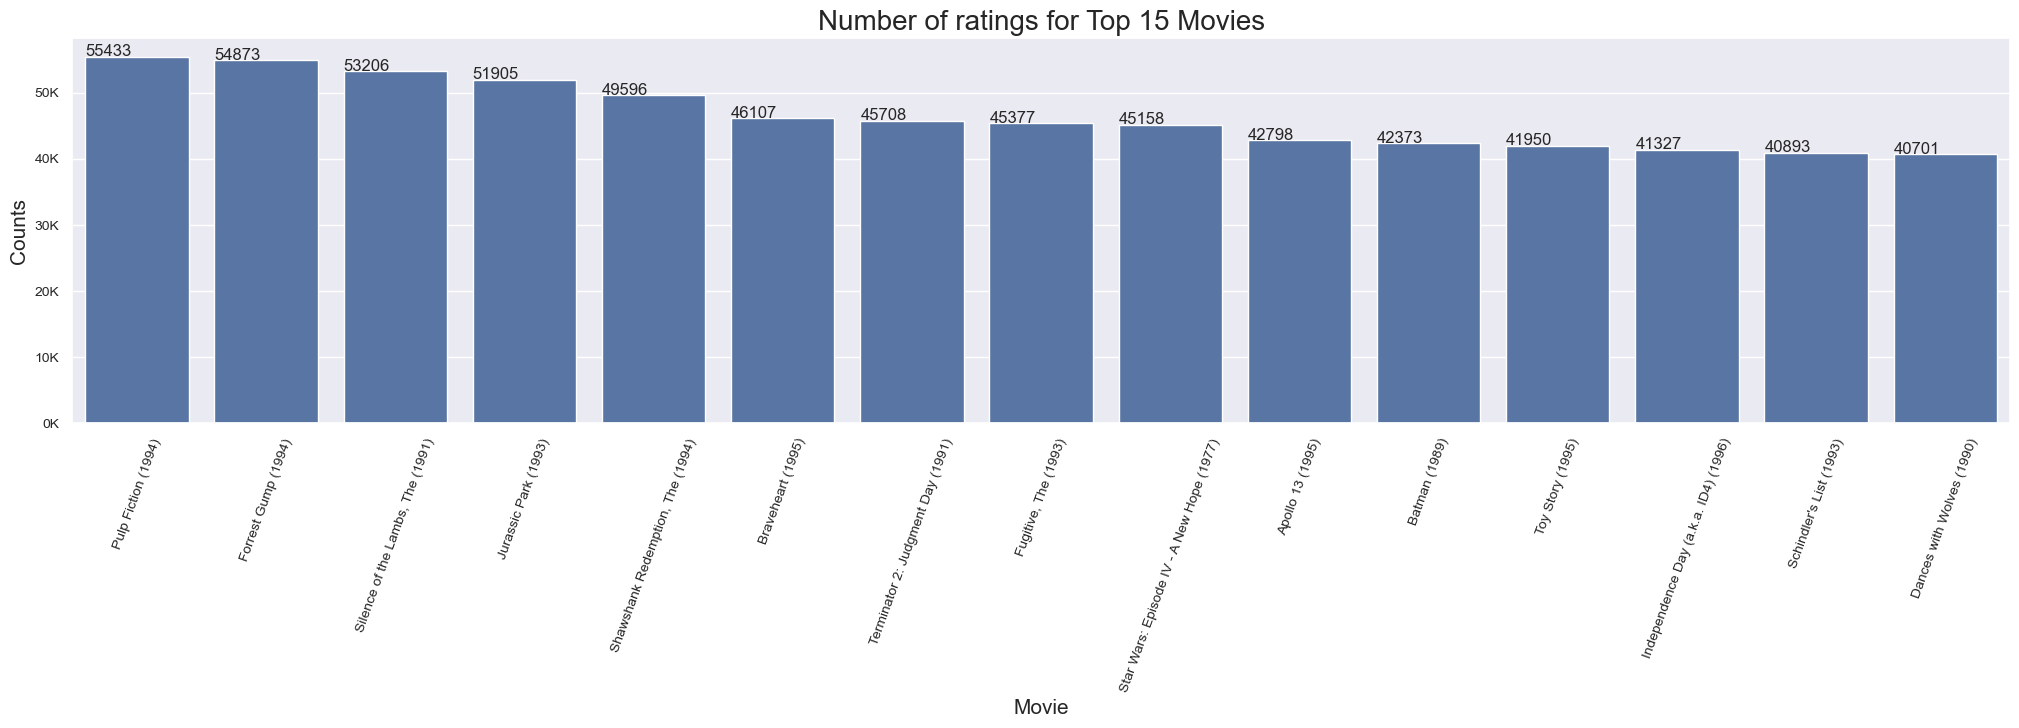

In [63]:
# Visualizing top 5 movies heavily rated movies.

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="title", y="rating", data=no_of_ratings_per_movie[:15], ax=axes)
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

axes.set_yticklabels([ChangingLabelsInK(num) for num in axes.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Number of ratings for Top 15 Movies", fontsize = 20)
plt.xlabel("Movie", fontsize = 15)
plt.xticks(rotation=70, fontsize=10)
plt.ylabel("Counts", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

In [64]:
# Calculating average ratings for movies

avg_ratings_per_movie = Train_Data.groupby(by = ["movieId", "title"], as_index=False)["rating"].mean()
avg_ratings_per_movie = avg_ratings_per_movie.reset_index(drop=True)
avg_ratings_per_movie = avg_ratings_per_movie.merge(no_of_ratings_per_movie[["movieId", "rating"]], how="left", on="movieId")
avg_ratings_per_movie.rename(columns={"rating_x":"avg_rating", "rating_y": "num_of_rating"}, inplace=True)
avg_ratings_per_movie = avg_ratings_per_movie.sort_values("num_of_rating", ascending=False)

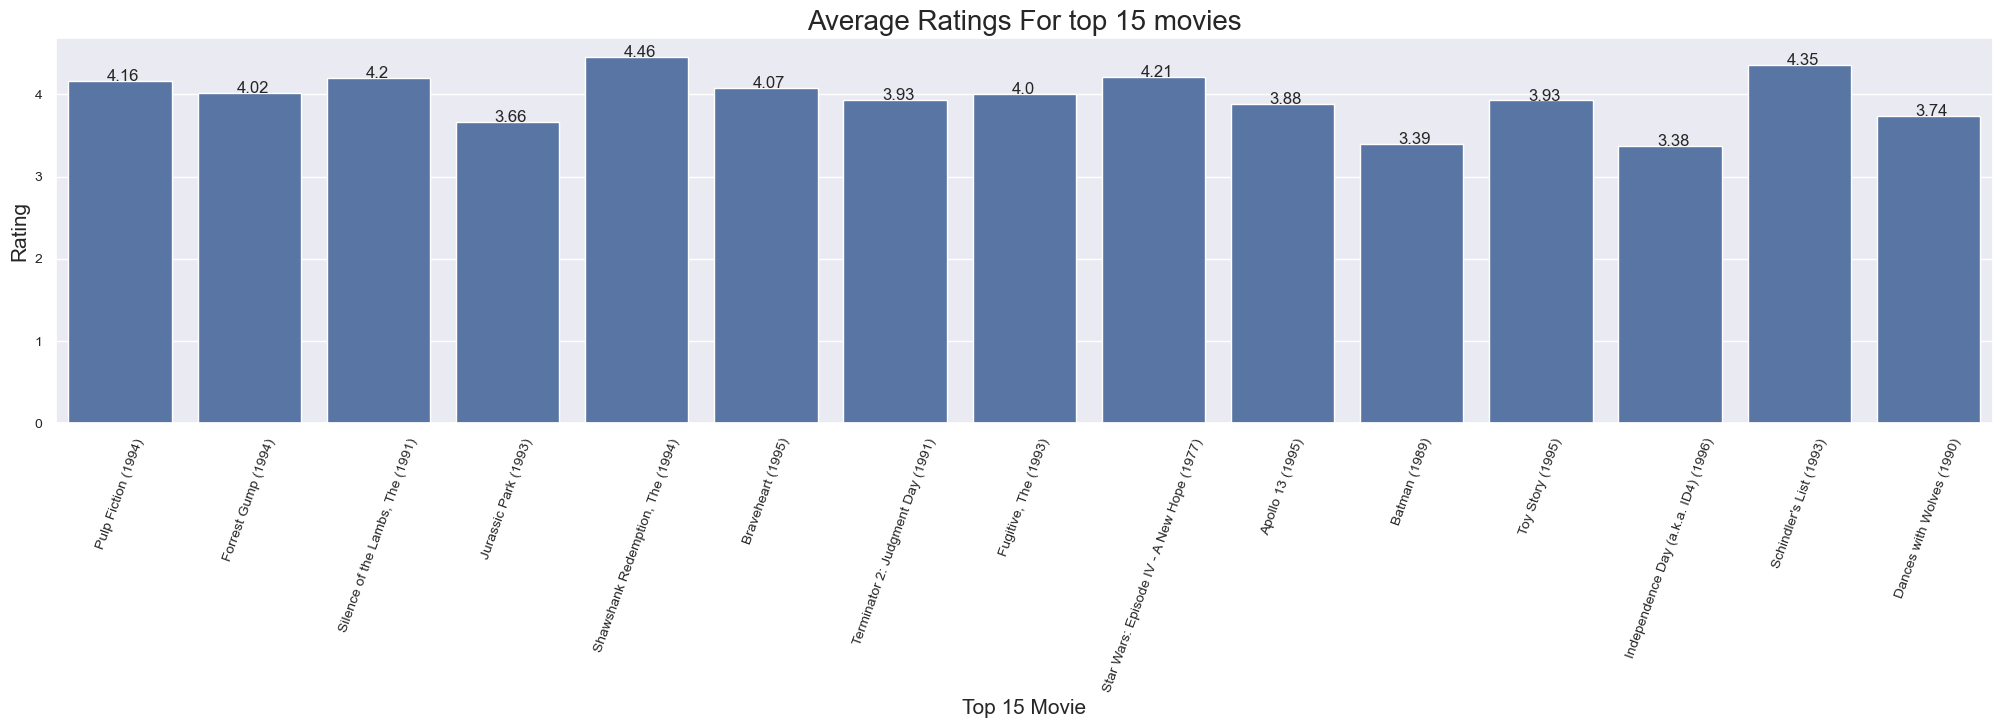

In [65]:
# Visualizing the average ratings by individual Days of the Week

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="title", y="avg_rating", data=avg_ratings_per_movie[:15], ax=axes)

for p in axes.patches:
    axes.annotate('{}'.format(round(p.get_height(), 2)), (p.get_x()+0.3, p.get_height()))

plt.tick_params(labelsize = 15)
plt.title("Average Ratings For top 15 movies", fontsize = 20)
plt.xlabel("Top 15 Movie", fontsize = 15)
plt.xticks(rotation=70, fontsize=10)
plt.ylabel("Rating", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

Observations:  

Les films cultes des années 1990 ont été les plus évalués.

Pulp Fiction, Forrest Gump, Shawshank Redemption et Silence of the Lambs ont été évalués plus de 50 000 fois.

Shawshank Redemption a la moyenne d'évaluation la plus élevée de 4,56, basée sur plus de 50 000 évaluations.

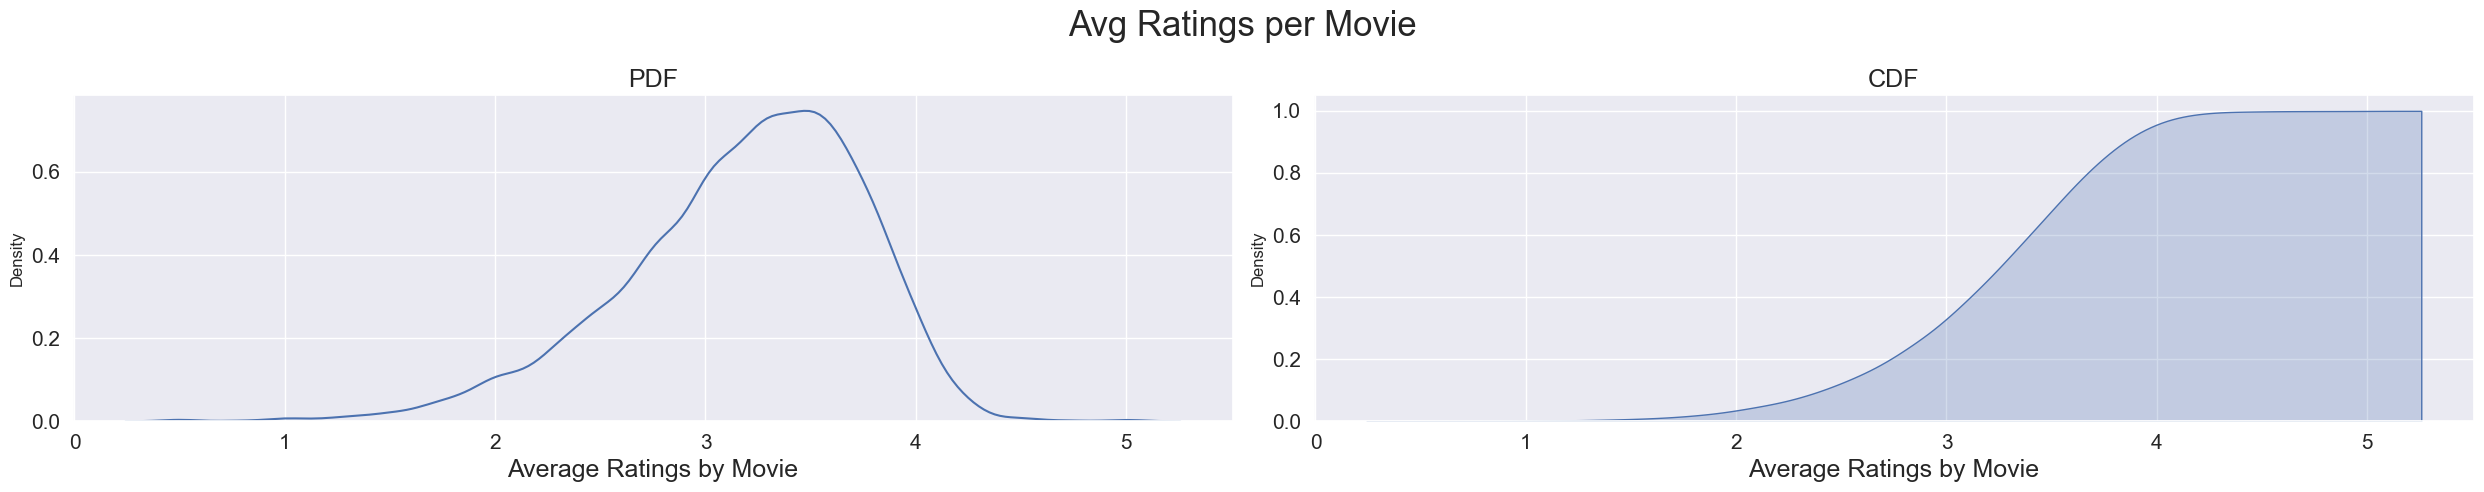

In [66]:
# Plotting the PDF and CDF for Avg. rating by Movies

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 5))
fig.suptitle("Avg Ratings per Movie", fontsize=25)

sns.distplot(avg_ratings_per_movie["avg_rating"], hist = False, ax = axes[0], label = "PDF")
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Average Ratings by Movie", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(avg_ratings_per_movie["avg_rating"], cumulative = True, ax = axes[1], shade=True, label = "CDF")
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Average Ratings by Movie", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

Observations:

La distribution des évaluations moyennes des films suit une forme relativement normale.

Le cdf montre que l'évaluation moyenne est plus fréquente après 3.

In [67]:
Train_Data.head()

,userId,movieId,rating,date,title,genres,DayOfWeek,Weekday
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime,Monday,0
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,Monday,0
2,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance,Monday,0
3,131160,21,3.0,1995-01-09,Get Shorty (1995),Comedy|Crime|Thriller,Monday,0
4,85252,7,5.0,1996-01-29,Sabrina (1995),Comedy|Romance,Monday,0


### **3.3. Feature Engineering**

Maintenant que nous avons terminé la partie exploration des données, nous pouvons commencer l'ingénierie des caractéristiques (Feature Engineering) afin de préparer les données pour les algorithmes de Machine Learning.

#### **3.3.1 Creating Matrices**

Nous allons créer des matrices telles que : la matrice Utilisateur-Objet, la matrice Utilisateur-Utilisateur et la matrice de similarité Objet-Objet.

---

#####**1. Creating USER-ITEM sparse matrix.**

La création d'une matrice utilisateur-item creuse est une étape clé pour structurer efficacement les données de notation dans un format adapté aux algorithmes de recommandation. En représentant les utilisateurs en lignes, les films en colonnes et les notes comme valeurs, cette approche optimise le stockage mémoire en ignorant les interactions manquantes (99% de données vides). Ce format sparse est indispensable pour appliquer des méthodes comme  le calcul de similarités (KNN), tout en gérant le problème de sparsity typique des systèmes de recommandation où chaque utilisateur n'a évalué qu'une fraction infime des films disponibles.

In [68]:
# Path for loading/saving files

file_path = "/content/drive/MyDrive/Colab Datasets/Movie Recommendation"

In [69]:
# Creating/loading user-movie sparse matrix for train data
import os
startTime = datetime.now()

print("Creating USER_ITEM sparse matrix for train Data..")
os.makedirs(file_path, exist_ok=True)
if os.path.isfile(file_path + "/TrainUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TrainUISparseData = sparse.load_npz(file_path + "/TrainUISparseData.npz")
    print("Shape of Train Sparse matrix = "+str(TrainUISparseData.shape))
else:
    print("We are creating sparse data..")
    TrainUISparseData = sparse.csr_matrix((Train_Data.rating, (Train_Data.userId, Train_Data.movieId)))
    print("Creation done. Shape of sparse matrix : ", str(TrainUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz(file_path + "/TrainUISparseData.npz", TrainUISparseData)
    print("Done\n")

print("Time taken : ", datetime.now() - startTime)

Creating USER_ITEM sparse matrix for train Data..
We are creating sparse data..
Creation done. Shape of sparse matrix :  (138494, 14334)
Saving it into disk for furthur usage.
Done

Time taken :  0:00:30.727732


In [70]:
rows,cols = TrainUISparseData.shape
presentElements = TrainUISparseData.count_nonzero()

print("Sparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Train matrix : 99.19401432357586% 


In [71]:
# Creating/loading user-movie sparse matrix for test data

startTime = datetime.now()

print("Creating USER_ITEM sparse matrix for test Data..")

if os.path.isfile(file_path + "/TestUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TestUISparseData = sparse.load_npz(file_path + "/TestUISparseData.npz")
    print("Shape of Test Sparse Matrix : ", str(TestUISparseData.shape))
else:
    print("We are creating sparse data..")
    TestUISparseData = sparse.csr_matrix((Test_Data.rating, (Test_Data.userId, Test_Data.movieId)))
    print("Creation done. Shape of sparse matrix : ", str(TestUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz(file_path + "/TestUISparseData.npz", TestUISparseData)
    print("Done\n")

print("Time Taken : ", datetime.now() - startTime)

Creating USER_ITEM sparse matrix for test Data..
We are creating sparse data..
Creation done. Shape of sparse matrix :  (138494, 27279)
Saving it into disk for furthur usage.
Done

Time Taken :  0:00:07.709353


In [72]:
rows,cols = TestUISparseData.shape
presentElements = TestUISparseData.count_nonzero()

print("Sparsity Of Test matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Test matrix : 99.89412185078294% 


Observations:

La forme de la matrice creuse dépend de la valeur la plus élevée de userId et de la valeur la plus élevée de movieId.

Dans l'ensemble de test, il y a quelques utilisateurs de l'ensemble d'entraînement qui ne sont pas présents dans l'ensemble de test.

Pour les movieId, il y a moins de films dans l'ensemble d'entraînement par rapport à l'ensemble de test. Cela provient du fait que nous avons divisé les données en fonction du temps, et les films plus récents se trouvent dans l'ensemble de test.

La sparsité de l'ensemble d'entraînement est de 99,19%, tandis que la sparsité de l'ensemble de test est de 99,89%.

In [73]:
# Function to Calculate Average rating for users or movies from User-movie sparse matrix

def getAverageRatings(sparseMatrix, if_user):

    #axis = 1 means rows and axis = 0 means columns
    ax = 1 if if_user else 0

    sumOfRatings = sparseMatrix.sum(axis = ax).A1
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}

    return averageRatings

In [74]:
AvgRatingUser = getAverageRatings(TrainUISparseData, True)
AvgRatingMovie = getAverageRatings(TrainUISparseData, False)
train_users = len(AvgRatingUser)
uncommonUsers = total_users - train_users

print("Total no. of Users : ", total_users)
print("No. of Users in Train data : ", train_users)
print("No. of Users not present in Train data : {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total no. of Users :  138493
No. of Users in Train data :  112466
No. of Users not present in Train data : 26027(19.0%)


In [75]:
train_movies = len(AvgRatingMovie)
uncommonMovies = total_movies - train_movies

print("Total no. of Movies : ", total_movies)
print("No. of Movies in Train data : ", train_movies)
print("No. of Movies not present in Train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total no. of Movies :  26744
No. of Movies in Train data :  12387
No. of Movies not present in Train data = 14357(54.0%)


Observations:

Le Système de Recommandation souffre du problème du Cold Start, qu'il faut traiter intelligemment pour concevoir un système efficace.

Il y a 26 027 utilisateurs, soit 19% des utilisateurs, qui ne sont pas présents dans les données d'entraînement.

Il y a 12 387 films, soit 54% des films, qui ne sont pas présents dans les données d'entraînement.

---

#####**2. Creating Similarity Matrix**

Le calcul de la matrice de similarité utilisateur-utilisateur ou article-article est impossible si la puissance de calcul est limitée, étant donné que nous avons un vecteur utilisateur de taille 112K. Il y aurait alors une matrice de taille 14K x 14K.

D'autre part, si nous essayons de réduire la dimension, par exemple, avec un SVD tronqué, cela prendrait encore plus de temps, car le SVD tronqué crée une matrice dense et la quantité de multiplication nécessaire pour créer la matrice de similarité utilisateur-utilisateur augmenterait de manière dramatique.

En guise de solution, nous allons maintenir un vecteur binaire pour les utilisateurs, qui nous indique si nous avons déjà calculé la similarité pour cet utilisateur ou non, ou calculer les 1000 utilisateurs les plus similaires pour cet utilisateur donné, et ajouter ces informations à notre structure de données, afin que nous puissions y accéder directement (utilisateurs similaires) sans avoir à la recalculer.

Si la similarité a déjà été calculée, nous pouvons simplement l'obtenir directement depuis notre structure de données, qui contient ces informations. En production, nous pourrions devoir recalculer les similarités si elles ont été calculées il y a longtemps, car les préférences des utilisateurs évoluent avec le temps. Si nous pouvions maintenir un timer, qui, lorsqu'il expire, nous obligerait à mettre à jour (recalculer) les similarités.

La structure de données à utiliser est totalement dépendante de l'implémentation. Une méthode simple consiste à maintenir un dictionnaire de dictionnaires :

clé : userid

valeur : un autre dictionnaire

clé : _Similar User

valeur : Valeur de similarité


---

**2.1. Computing Item-Item Similarity Matrix**

In [76]:
# Computing user-user similarity matrix for the train data
# We have 138K sized sparse vectors using which a 14K x 14K movie similarity matrix would be calculated

start = datetime.now()

if not os.path.isfile(file_path + "/m_m_similarity.npz"):
    print("Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...")
    m_m_similarity = cosine_similarity(TrainUISparseData.T, dense_output = False)
    print("Dimension of Matrix : ", m_m_similarity.shape)
    print("Storing the Movie Similarity matrix on disk for further usage")
    sparse.save_npz(file_path + "/m_m_similarity.npz", m_m_similarity)
else:
    print("File exists in the disk. Loading the file...")
    m_m_similarity = sparse.load_npz(file_path + "/m_m_similarity.npz")
    print("Dimension of Matrix : ", m_m_similarity.shape)

print("The time taken to compute movie-movie similarity matrix is : ", datetime.now() - start)

Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...
Dimension of Matrix :  (14334, 14334)
Storing the Movie Similarity matrix on disk for further usage
The time taken to compute movie-movie similarity matrix is :  0:06:40.119359


In [77]:
# Creating a function to take Movie Name and generate the top matched name and generate its N similar movies based on M-M Similary

def GetSimilarMoviesUsingMovieMovieSimilarity(movie_name, num_of_similar_movies):
    matches = process.extract(movie_name, movie_list_in_training["title"], scorer=fuzz.partial_ratio)
    if len(matches) == 0:
        return "No Match Found"
    movie_id = movie_list_in_training.iloc[matches[0][2]]["movieId"]
    similar_movie_id_list = np.argsort(-m_m_similarity[movie_id].toarray().ravel())[0:num_of_similar_movies+1]
    sm_df = movie_list_in_training[movie_list_in_training["movieId"].isin(similar_movie_id_list)]
    sm_df["order"] = sm_df.apply(lambda x: list(similar_movie_id_list).index(x["movieId"]), axis=1)

    return sm_df.sort_values("order")

In [79]:
# Picking random movie and checking it's top 10 most similar movies

GetSimilarMoviesUsingMovieMovieSimilarity("Superman", 10)

,movieId,title,genres,order
2526,2557,Superman II (1980),Action|Sci-Fi,0
2530,2558,Superman III (1983),Action|Adventure|Sci-Fi,1
2527,2556,Superman (1978),Action|Adventure|Sci-Fi,2
2531,2559,Superman IV: The Quest for Peace (1987),Action|Adventure|Sci-Fi,3
2877,2900,RoboCop (1987),Action|Crime|Drama|Sci-Fi|Thriller,4
1340,1345,Star Trek III: The Search for Spock (1984),Action|Adventure|Sci-Fi,5
2012,2022,Tron (1982),Action|Adventure|Sci-Fi,6
1339,1344,Star Trek II: The Wrath of Khan (1982),Action|Adventure|Sci-Fi|Thriller,7
1341,1346,Star Trek IV: The Voyage Home (1986),Adventure|Comedy|Sci-Fi,8
2807,2831,Total Recall (1990),Action|Adventure|Sci-Fi|Thriller,9


---

**2.2. Computing User-User Similarity Matrix.**



In [80]:
# Getting highest uder id

row_index, col_index = TrainUISparseData.nonzero()
unique_user_id = np.unique(row_index)
print("Max User id is :", np.max(unique_user_id))

Max User id is : 138493


Time elapsed for 20 users = 0:00:29.030121sec
Time elapsed for 40 users = 0:00:56.026929sec
Time elapsed for 60 users = 0:01:24.833632sec
Time elapsed for 80 users = 0:01:52.578878sec
Time elapsed for 100 users = 0:02:19.076333sec
Average Time taken to compute similarity matrix for 1 user = 1.3790395092964172seconds


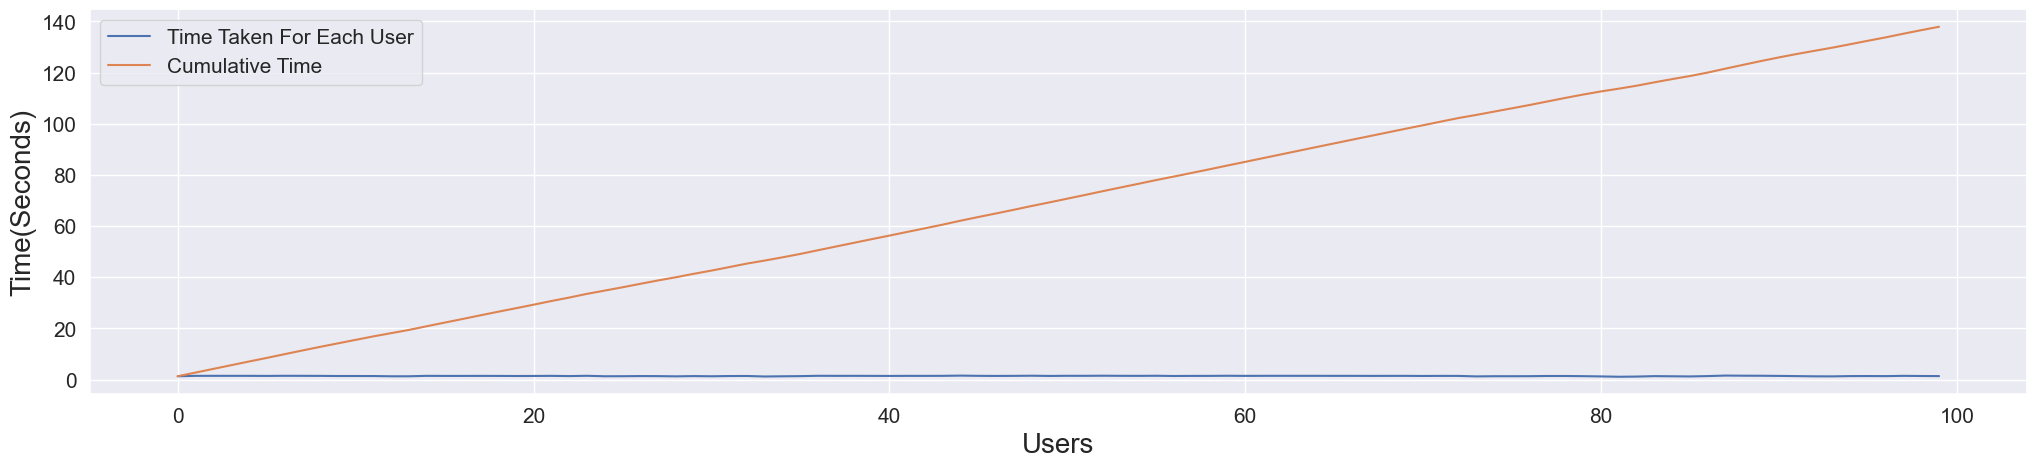

In [81]:
# Here, we are calculating user-user similarity matrix only for first 100 users in our sparse matrix. And we are calculating
# Top 100 most similar users with them.

def getUser_UserSimilarity(sparseMatrix, top = 100):
    startTimestamp20 = datetime.now()

    row_index, col_index = sparseMatrix.nonzero()
    rows = np.unique(row_index)
    similarMatrix = np.zeros(13849300).reshape(138493,100)    # 138493*100 = 13849300. As we are building similarity matrix only
    #for top 100 most similar users.
    timeTaken = []
    howManyDone = 0
    for row in rows[:top]:
        howManyDone += 1
        startTimestamp = datetime.now().timestamp()  #it will give seconds elapsed
        sim = cosine_similarity(sparseMatrix.getrow(row), sparseMatrix).ravel()
        top100_similar_indices = sim.argsort()[-top:]
        top100_similar = sim[top100_similar_indices]
        similarMatrix[row] = top100_similar
        timeforOne = datetime.now().timestamp() - startTimestamp
        timeTaken.append(timeforOne)
        if howManyDone % 20 == 0:
            print("Time elapsed for {} users = {}sec".format(howManyDone, (datetime.now() - startTimestamp20)))
    print("Average Time taken to compute similarity matrix for 1 user = "+str(sum(timeTaken)/len(timeTaken))+"seconds")

    sns.set(style="darkgrid")
    fig = plt.figure(figsize = (25, 5))
    plt.plot(timeTaken, label = 'Time Taken For Each User')
    plt.plot(np.cumsum(timeTaken), label='Cumulative Time')
    plt.legend(loc='upper left', fontsize = 15)
    plt.xlabel('Users', fontsize = 20)
    plt.ylabel('Time(Seconds)', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()

    return similarMatrix

simMatrix = getUser_UserSimilarity(TrainUISparseData, 100)

Le graphique illustre le temps de calcul pour déterminer la similarité entre les 100 premiers utilisateurs. La courbe bleue (temps par utilisateur) montre une forte variabilité, allant de quelques secondes à 60-80 secondes pour certains, reflétant des différences dans le nombre d'interactions. La courbe orange (temps cumulatif) atteint ~1000 secondes (16-17 minutes) pour l'ensemble des 100 utilisateurs, avec des sauts correspondant aux pics de la courbe bleue.

In [82]:
# Calculating user-user similarity only for particular users in our sparse matrix and return user_ids

def Calculate_User_User_Similarity(sparseMatrix, user_id, num_of_similar_users=10):

    if user_id in unique_user_id:
        # Calculating the cosine similarity for user_id with all the "userId"
        sim = cosine_similarity(sparseMatrix.getrow(user_id), sparseMatrix).ravel()
        # Sorting the indexs(user_id) based on the similarity score for all the user ids
        top_similar_user_ids = sim.argsort()[::-1]
        # Sorted the similarity values
        top_similarity_values = sim[top_similar_user_ids]

    return top_similar_user_ids[1: num_of_similar_users+1]

In [83]:
# Getting top 5 users similar to userId: 1

similar_users_1 = Calculate_User_User_Similarity(TrainUISparseData, 1, 5)
similar_users_1

array([81275, 62235,  2595, 75328, 34101], dtype=int64)

---

#### **3.3.2 Feature Extraction**

Nous pouvons maintenant commencer à extraire des caractéristiques significatives afin de préparer les données pour les algorithmes de Machine Learning.

In [84]:
# Path for saving/loading files

file_path = "/content/drive/MyDrive/Colab Datasets/Movie Recommendation"

In [85]:
# Since the given dataset might not completely fit into computaton capacity that we have, we will sample the data and work it

# Function for Sampling random movies and users to reduce the size of rating matrix
def get_sample_sparse_matrix(sparseMatrix, n_users, n_movies, matrix_name):

    np.random.seed(15)   #this will give same random number everytime, without replacement
    startTime = datetime.now()

    users, movies, ratings = sparse.find(sparseMatrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)

    userS = np.random.choice(uniq_users, n_users, replace = False)
    movieS = np.random.choice(uniq_movies, n_movies, replace = False)
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    sparse_sample = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), shape = (max(userS)+1, max(movieS)+1))

    print("Sparse Matrix creation done. Saving it for later use.")
    sparse.save_npz(file_path + "/" + matrix_name, sparse_sample)
    print("Shape of Sparse Sampled Matrix = " + str(sparse_sample.shape))
    print("Time taken : ", datetime.now() - startTime)

    return sparse_sample

In [86]:
# Creating Sample Sparse Matrix for Train Data

if not os.path.isfile(file_path + "/TrainUISparseData_Sample.npz"):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    train_sample_sparse = get_sample_sparse_matrix(TrainUISparseData, 5000, 1000, "TrainUISparseData_Sample.npz")
else:
    print("File is already present in the disk. Loading the file...")
    train_sample_sparse = sparse.load_npz(file_path + "/TrainUISparseData_Sample.npz")
    print("Shape of Train Sample Sparse Matrix = " + str(train_sample_sparse.shape))

Sample sparse matrix is not present in the disk. We are creating it...
Sparse Matrix creation done. Saving it for later use.
Shape of Sparse Sampled Matrix = (138488, 14312)
Time taken :  0:00:12.498283


In [87]:
# Creating Sample Sparse Matrix for Test Data

if not os.path.isfile(file_path + "/TestUISparseData_Sample.npz"):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    test_sample_sparse = get_sample_sparse_matrix(TestUISparseData, 2000, 200, "TestUISparseData_Sample.npz")
else:
    print("File is already present in the disk. Loading the file...")
    test_sample_sparse = sparse.load_npz(file_path + "/TestUISparseData_Sample.npz")
    print("Shape of Test Sample Sparse Matrix = " + str(test_sample_sparse.shape))

Sample sparse matrix is not present in the disk. We are creating it...
Sparse Matrix creation done. Saving it for later use.
Shape of Sparse Sampled Matrix = (138456, 27198)
Time taken :  0:00:03.057130


In [ ]:
# Checking the shape of Training and test data

print("Shape of Train Sparse Matrix : ", train_sample_sparse.shape)
print("Shape of Test Sparse Matrix : ", test_sample_sparse.shape)

Shape of Train Sparse Matrix :  (138488, 14312)
Shape of Test Sparse Matrix :  (138456, 27198)


In [88]:
# Calculating few GlobalAverageRating, AvgMovieRating, AvgUserRating and TotalNoOfRatings

globalAvgRating = np.round((train_sample_sparse.sum()/train_sample_sparse.count_nonzero()), 2)
globalAvgMovies = getAverageRatings(train_sample_sparse, False)
globalAvgUsers = getAverageRatings(train_sample_sparse, True)
print("Global average of all movies ratings in Train Set is : ", globalAvgRating)
print("No. of ratings in the train matrix is : ", train_sample_sparse.count_nonzero())

Global average of all movies ratings in Train Set is :  3.5
No. of ratings in the train matrix is :  54216


In [89]:
# Function to extract features and create row using the sparse matrix

def CreateFeaturesForTrainData(SampledSparseData, TrainSampledSparseData):

    startTime = datetime.now()

    # Extracting userId list, movieId list and Ratings
    sample_users, sample_movies, sample_ratings = sparse.find(SampledSparseData)

    print("No. of rows in the returned dataset : ", len(sample_ratings))

    count = 0
    data = []

    for user, movie, rating in zip(sample_users, sample_movies, sample_ratings):

        row = list()

#----------------------------------Appending "user Id" average, "movie Id" average & global average rating-----------#
        row.append(user)
        row.append(movie)
        row.append(globalAvgRating)

#----------------------------------Appending "user" average, "movie" average & rating of "user""movie"-----------#
        try:
            row.append(globalAvgUsers[user])
        except (KeyError):
            global_average_rating = globalAvgRating
            row.append(global_average_rating)
        except:
            raise
        try:
            row.append(globalAvgMovies[movie])
        except (KeyError):
            global_average_rating = globalAvgRating
            row.append(global_average_rating)
        except:
            raise

#----------------------------------Ratings given to "movie" by top 5 similar users with "user"--------------------#
        try:
            similar_users = cosine_similarity(TrainSampledSparseData[user], TrainSampledSparseData).ravel()
            similar_users_indices = np.argsort(-similar_users)[1:]
            similar_users_ratings = TrainSampledSparseData[similar_users_indices, movie].toarray().ravel()
            top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
            top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "movie" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "movie" average rating.
            row.extend(top_similar_user_ratings)
        #########Cold Start Problem, for a new user or a new movie#########
        except (IndexError, KeyError):
            global_average_rating = [globalAvgRating]*5
            row.extend(global_average_rating)
        except:
            raise

#----------------------------------Ratings given by "user" to top 5 similar movies with "movie"------------------#
        try:
            similar_movies = cosine_similarity(TrainSampledSparseData[:,movie].T, TrainSampledSparseData.T).ravel()
            similar_movies_indices = np.argsort(-similar_movies)[1:]
            similar_movies_ratings = TrainSampledSparseData[user, similar_movies_indices].toarray().ravel()
            top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
            top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
            row.extend(top_similar_movie_ratings)
        ########Cold Start Problem, for a new user or a new movie#########
        except (IndexError, KeyError):
            global_average_rating = [globalAvgRating] * 5
            row.extend(global_average_rating)
        except:
            raise

#----------------------------------Appending rating of "user""movie"-----------#
        row.append(rating)

        count += 1

        data.append(row)

        if count % 5000 == 0:
            print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))

    print("Total Time for {} rows = {}".format(len(data), (datetime.now() - startTime)))
    print("Completed..")
    return data

Cette fonction transforme la matrice creuse utilisateur-film en un jeu de données enrichi pour l'entraînement des modèles de recommandation. Elle extrait d'abord les interactions de base (utilisateur, film, note), puis ajoute des features clés comme les moyennes (globale, par utilisateur, par film) et les notes des 5 utilisateurs/films les plus similaires (calculées par similarité cosinus). Elle gère aussi le problème de Cold Start en remplaçant les données manquantes par des moyennes par défaut. Structurées et optimisées, ces données permettent aux algorithmes (SVD++, XGBoost, etc.) de mieux prédire les préférences des utilisateurs, améliorant ainsi la qualité des recommandations.

In [90]:
# Using sampled train data, creating Features for each row and saving it into the list

data_rows = CreateFeaturesForTrainData(train_sample_sparse, train_sample_sparse)

No. of rows in the returned dataset :  54216
Done for 5000. Time elapsed: 0:03:10.035147
Done for 10000. Time elapsed: 0:06:32.065116
Done for 15000. Time elapsed: 0:09:42.156851
Done for 20000. Time elapsed: 0:12:52.031920
Done for 25000. Time elapsed: 0:15:59.883338
Done for 30000. Time elapsed: 0:19:12.665008
Done for 35000. Time elapsed: 0:22:25.970613
Done for 40000. Time elapsed: 0:25:40.922269
Done for 45000. Time elapsed: 0:28:56.250970
Done for 50000. Time elapsed: 0:32:23.965968
Total Time for 54216 rows = 0:35:11.388826
Completed..


Cette étape permet de transformer les données brutes en caractéristiques structurées pour alimenter les modèles de recommandation. La fonction crée pour chaque évaluation (utilisateur-film) un ensemble de features clés : identifiants, note réelle, moyennes (globale/utilisateur/film), ainsi que les notes des utilisateurs et films similaires. Ces informations enrichies, combinées à une gestion intelligente des données manquantes (moyennes par défaut), offrent aux algorithmes comme SVD ou XGBoost une vision complète des préférences utilisateurs, essentielle pour générer des recommandations pertinentes et personnalisées.

In [91]:
# Using sampled train data, creating Features for each row and saving it into the list

test_data_rows = CreateFeaturesForTrainData(test_sample_sparse, train_sample_sparse)

No. of rows in the returned dataset :  2084
Total Time for 2084 rows = 0:01:00.600909
Completed..


In [92]:
# Creating the pandas dataframe from the data rows extracted from the sparse matrix for train and test set

names = ["User_ID", "Movie_ID", "Global_Average", "User_Average", "Movie_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "Rating"]
train_regression_data = pd.DataFrame(data_rows, columns=names)
test_regression_data = pd.DataFrame(test_data_rows, columns=names)

In [93]:
# Saving the df to drive for future use

train_regression_data.to_csv(file_path + "/Training_Data_For_Regression.csv")
test_regression_data.to_csv(file_path + "/Testing_Data_For_Regression.csv")

In [94]:
# Loading the train and test csv files

# Path for saving/loading files
file_path = "/content/drive/MyDrive/Colab Datasets/Movie Recommendation"

print("File is already present in the disk. Loading the file...")

train_regression_data = pd.read_csv(file_path + "/Training_Data_For_Regression.csv")
train_regression_data = train_regression_data.drop(["Unnamed: 0"], axis=1)

test_regression_data = pd.read_csv(file_path + "/Testing_Data_For_Regression.csv")
test_regression_data = test_regression_data.drop(["Unnamed: 0"], axis=1)

print("Done..")

File is already present in the disk. Loading the file...
Done..


In [95]:
# Checking the shape and first few records for train data

print("The shape of the dataframe is : ", train_regression_data.shape)
print("Number of missing Values : ", train_regression_data.isnull().sum().sum())
train_regression_data.head()

The shape of the dataframe is :  (54216, 16)
Number of missing Values :  0


,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating
0,34,140,3.5,4.0,3.525107,4.0,3.0,4.0,5.0,4.0,4.0,5.0,3.0,5.0,3.0,4.0
1,34,185,3.5,4.0,2.967161,5.0,4.0,3.0,4.0,3.0,5.0,5.0,4.0,4.0,4.0,3.0
2,34,207,3.5,4.0,2.831174,4.0,4.0,3.0,3.0,4.0,5.0,4.0,3.0,3.0,4.0,5.0
3,34,287,3.5,4.0,3.358491,5.0,4.0,4.0,3.0,1.0,3.0,5.0,4.0,3.0,4.0,4.0
4,34,491,3.5,4.0,3.387127,5.0,5.0,5.0,2.0,3.0,4.0,4.0,5.0,3.0,5.0,4.0


In [96]:
# Checking the shape and first few records for test data

print("The shape of the dataframe is : ", test_regression_data.shape)
print("Number of missing Values : ", test_regression_data.isnull().sum().sum())
test_regression_data.head()

The shape of the dataframe is :  (2084, 16)
Number of missing Values :  0


,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating
0,133,1235,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.5
1,133,5891,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.0
2,133,8102,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,5.0
3,133,19090,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.0
4,285,17284,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,5.0


Observations:

The description of the features are stated below:
1. User_ID: ID of a this User
2. Movie_ID: ID of a this Movie
3. Global_Average: Global Average Rating
4. User_Average: Average Rating of this User
5. Movie_Average: Average Rating of this Movie
6. Ratings given to this Movie by top 5 similar users with this User: (SUR1, SUR2, SUR3, SUR4, SUR5)
11. Ratings given by this User to top 5 similar movies with this Movie: (SMR1, SMR2, SMR3, SMR4, SMR5)
16. Rating: Rating given by this User to this Movie



Transformation des données d'entraînement :
Nous ne pouvons pas fournir directement des données brutes (film, utilisateur, note) pour entraîner un modèle dans la bibliothèque Surprise.
Ils utilisent un format spécifique pour les données d'entraînement et de test, qui est nécessaire pour entraîner des modèles tels que SVD, KNNBaseline, BaselineOnly, etc., dans Surprise.

Nous pouvons créer l'ensemble d'entraînement (trainset) :

soit à partir d'un fichier,

soit à partir d'un DataFrame Pandas.


Transformation des données de test :
Pour les données de test, nous devons simplement définir une liste de tuples sous la forme :

(utilisateur, film, note)


In [97]:
train_regression_data[['User_ID', 'Movie_ID', 'Rating']].head(5)

,User_ID,Movie_ID,Rating
0,34,140,4.0
1,34,185,3.0
2,34,207,5.0
3,34,287,4.0
4,34,491,4.0


In [98]:
# Using Surprise library Data Structures to store train data

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train_regression_data[["User_ID", "Movie_ID", "Rating"]], reader)
trainset = data.build_full_trainset()

In [99]:
# Creating tuple for test set

testset = list(zip(test_regression_data["User_ID"].values, test_regression_data["Movie_ID"].values, test_regression_data["Rating"].values))

---

## **4. Model Buliding**

Nous allons essayer de construire un modèle de régression pour prédire la note donnée par un utilisateur à un film basé sur les caractéristiques générées.

Nous avons deux métriques d'erreur :

RMSE : Erreur quadratique moyenne (Root Mean Square Error) : Le RMSE est l'erreur de chaque point qui est ensuite élevée au carré. Puis la moyenne est calculée. Enfin, la racine de cette moyenne est prise comme valeur finale.

MAPE : Erreur absolue moyenne en pourcentage (Mean Absolute Percentage Error) : Le MAPE, également connu sous le nom de mean absolute percentage deviation (MAPD), est une mesure de la précision de la prévision d'une méthode de prévision.

La différence entre At (valeur réelle) et Ft (valeur prédite) est divisée par la valeur réelle At. La valeur absolue dans ce calcul est additionnée pour chaque point prédit, puis divisée par le nombre de points ajustés n. Multiplier par 100% en fait une erreur en pourcentage.

où At est la valeur réelle et Ft est la valeur prédit.

.

# **Xgboost Regressor**

In [100]:
import pandas as pd
# Utilities to save the modelling results

error_cols = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]
error_table = pd.DataFrame(columns = error_cols)
model_train_evaluation = dict()
model_test_evaluation = dict()

In [101]:
# Function to save modelling results in a table

def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns = error_cols))
    error_table.reset_index(drop = True, inplace = True)

In [102]:
# Function to calulate RMSE and MAPE values

def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(abs((y_true - y_pred)/y_true))*100
    return rmse, mape

Cette partie fournit des utilitaires pour évaluer et sauvegarder les performances des modèles de recommandation. Il crée d'abord un DataFrame error_table pour stocker les résultats (RMSE et MAPE pour les ensembles d'entraînement et de test), ainsi que deux dictionnaires (model_train_evaluation et model_test_evaluation) pour conserver les évaluations. La fonction make_table() ajoute les métriques d'un modèle au DataFrame, tandis que error_metrics() calcule le RMSE (racine carrée de l'erreur quadratique moyenne) et le MAPE (erreur moyenne absolue en pourcentage) entre les valeurs réelles (y_true) et prédites (y_pred). Ces outils permettent de comparer facilement les performances des différents modèles testés.

In [103]:
# Apply Xgboost Regressor on the Train and Test Data

def train_test_xgboost(x_train, x_test, y_train, y_test, model_name):

    startTime = datetime.now()
    train_result = dict()
    test_result = dict()

    clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
    clf.fit(x_train, y_train)

    print("-" * 50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mape_train = error_metrics(y_train, y_pred_train)
    print("RMSE : {}".format(rmse_train))
    print("MAPE : {}".format(mape_train))
    train_result = {"RMSE": rmse_train, "MAPE": mape_train, "Prediction": y_pred_train}

    print("-" * 50)
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test, mape_test = error_metrics(y_test, y_pred_test)
    print("RMSE : {}".format(rmse_test))
    print("MAPE : {}".format(mape_test))
    test_result = {"RMSE": rmse_test, "MAPE": mape_test, "Prediction": y_pred_test}

    print("-"*50)
    print("Time Taken : ", datetime.now() - startTime)

    plot_importance(xgb, clf)
    make_table(model_name, rmse_train, mape_train, rmse_test, mape_test)

    return train_result, test_result

# Function to plot feature importance for a model

def plot_importance(model, clf):

    sns.set(style="darkgrid")
    fig = plt.figure(figsize = (25, 5))
    ax = fig.add_axes([0, 0, 1, 1])

    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()

Cette partie du code implémente un modèle XGBoost Regressor pour effectuer des prédictions sur des données d'entraînement et de test. La fonction train_test_xgboost() initialise le modèle avec 100 estimateurs et une parallélisation sur 10 jobs, puis l'entraîne sur les données fournies. Elle calcule et affiche les métriques RMSE (erreur quadratique moyenne) et MAPE (erreur moyenne absolue en pourcentage) pour évaluer les performances sur les ensembles d'entraînement et de test. Les résultats sont stockés dans des dictionnaires et ajoutés à un tableau global via make_table(). La fonction plot_importance() génère un graphique montrant l'importance des caractéristiques (features) selon leur score F, aidant à identifier les variables les plus influentes. Le temps d'exécution total est également mesuré et affiché pour optimiser le processus.



In [104]:
# in surprise prediction of every data point is returned as dictionary like this:
# "user: 196        item: 302        r_ui = 4.00   est = 4.06   {'actual_k': 40, 'was_impossible': False}"
# In this dictionary, "r_ui" is a key for actual rating and "est" is a key for predicted rating

def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted

def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

In [105]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

# Running Surprise model algorithms
def run_surprise(algo, trainset, testset, model_name):

    startTime = datetime.now()

    train = dict()
    test = dict()

    algo.fit(trainset)

#-----------------Evaluating Train Data------------------#
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}

#-----------------Evaluating Test Data------------------#
    print("-"*50)
    print("TEST DATA")
    test_pred = algo.test(testset)
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}

    print("-"*50)
    print("Time Taken = "+str(datetime.now() - startTime))

    make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)

    return train, test

Ce code implémente et évalue des algorithmes de recommandation de la bibliothèque Surprise. Il commence par fixer une graine aléatoire (my_seed = 15) pour assurer la reproductibilité des résultats. La fonction run_surprise() prend en entrée un algorithme (algo), un ensemble d'entraînement (trainset) et un ensemble de test (testset), puis effectue les étapes suivantes :

Entraînement du modèle : L'algorithme est entraîné sur trainset.

Évaluation sur les données d'entraînement :

Prédictions générées via algo.test(trainset.build_testset()).

Calcul du RMSE (erreur quadratique moyenne) et du MAPE (erreur moyenne absolue en pourcentage) à l'aide des fonctions get_ratings() et get_error().

Évaluation sur les données de test :

Mêmes métriques calculées pour testset.

Affichage des résultats : Temps d'exécution, RMSE et MAPE pour les deux ensembles.

Sauvegarde des résultats : Les métriques sont stockées dans un tableau global via make_table() et retournées sous forme de dictionnaires (train, test).

### **4.1 Train/test Splitting**

Nous pouvons diviser les données en ensembles d'entraînement et de test, et séparer les caractéristiques indépendantes et dépendantes.

In [106]:
# Creating the train-test X and y variables for the ML algos

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

### **4.2 Model Fitting**

Nous allons ajuster (fitter) divers modèles et vérifier leur précision


--------------------------------------------------
TRAIN DATA
RMSE : 0.7008309645108679
MAPE : 21.716820124068352
--------------------------------------------------
TEST DATA
RMSE : 1.0275424926240655
MAPE : 36.559631873351314
--------------------------------------------------
Time Taken :  0:00:00.670856


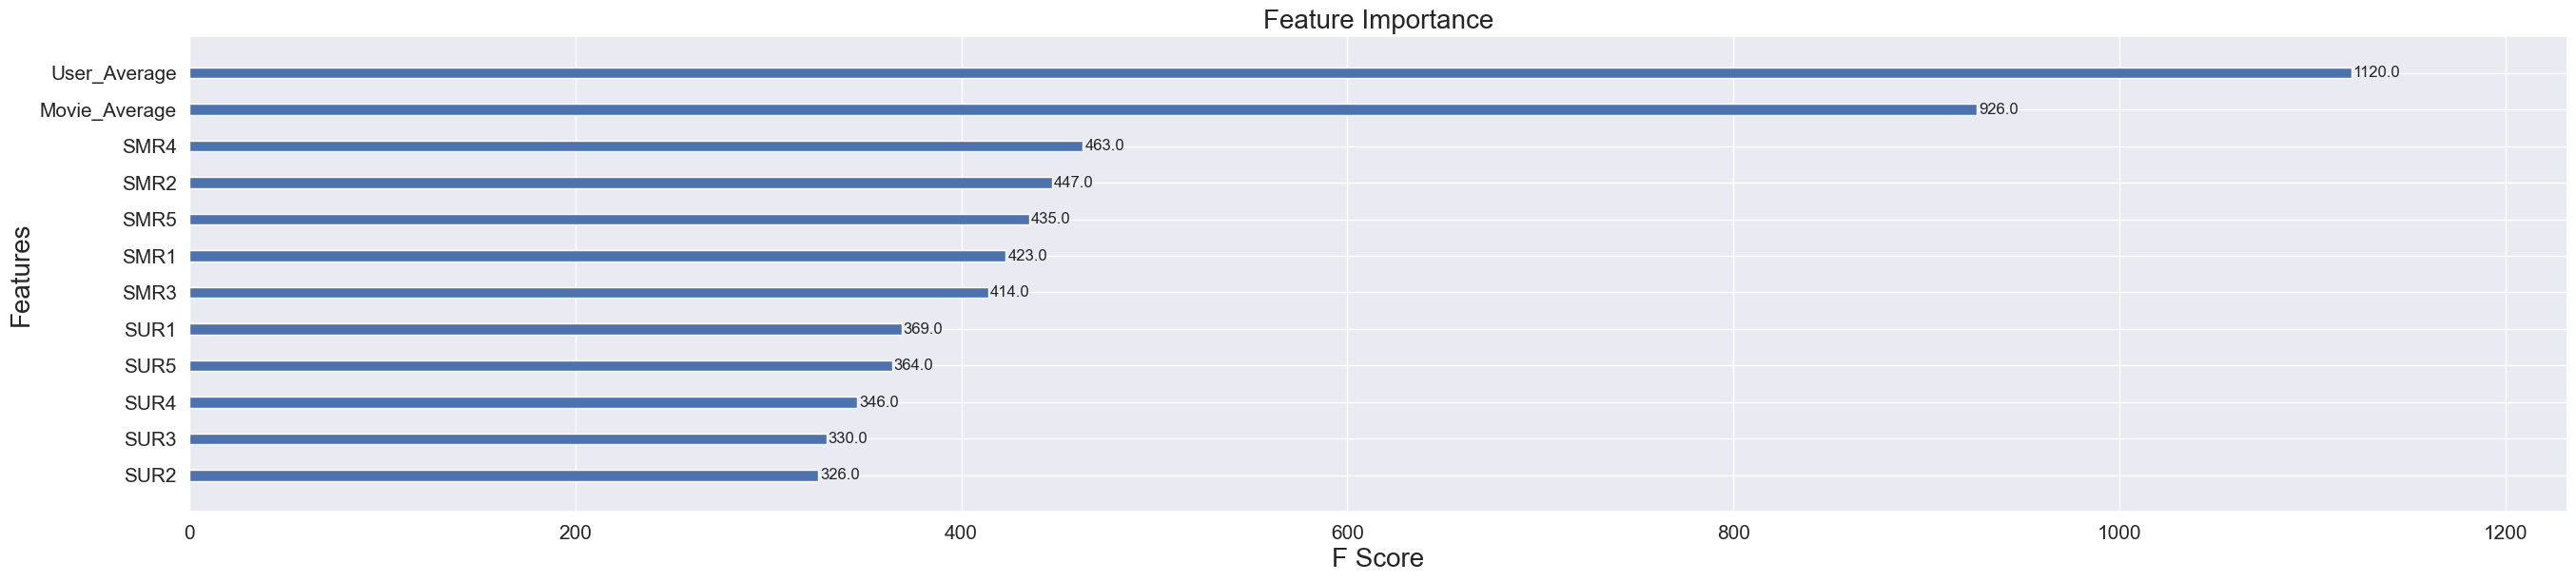

In [110]:
# Training the Xgboost Regression Model with the 13 features
def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    new_row = pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns=error_cols)
    error_table = pd.concat([error_table, new_row], ignore_index=True)

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGBoost_13")

model_test_evaluation["XGBoost_13"] = test_result


Observations:

"User_Average" semble de loin être la caractéristique la plus importante pour la prédiction des notes.

"Movie_Average" est la deuxième caractéristique la plus importante pour prédire les notes.

Les 5 meilleures notes des utilisateurs similaires et les 5 meilleures notes des films similaires ne semblent pas être des caractéristiques efficaces.

# **BaselineOnly**

In [111]:
# Applying BaselineOnly from the surprise library to predict the ratings

bsl_options = {"method":"sgd", "learning_rate":0.01, "n_epochs":25}

algo = BaselineOnly(bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "BaselineOnly")

model_train_evaluation["BaselineOnly"] = train_result
model_test_evaluation["BaselineOnly"] = test_result

Estimating biases using sgd...
--------------------------------------------------
TRAIN DATA
RMSE = 0.8259045077604161
MAPE = 27.49617857716931
--------------------------------------------------
TEST DATA
RMSE = 0.99957947564343
MAPE = 36.46801865595947
--------------------------------------------------
Time Taken = 0:00:00.906600


L'algorithme BaselineOnly utilisant SGD avec un taux d'apprentissage de 0.01 et 25 époques a été appliqué pour prédire les notes. Sur les données d'entraînement, il atteint un RMSE de 0.83 et un MAPE de 27.50%, montrant une capacité correcte à capturer les biais utilisateurs et items sans surajustement excessif. Sur les données de test, le RMSE descend à 0.999 et le MAPE est de 36.47%, ce qui est assez similaire au modèle XGBoost sur la métrique MAPE, bien que BaselineOnly soit légèrement meilleur en termes de RMSE sur le test. Cela suggère que, malgré sa simplicité, BaselineOnly parvient à des résultats compétitifs en s'appuyant uniquement sur des biais globaux utilisateur et item, sans modéliser des interactions complexes comme XGBoost. Le temps d'exécution est également très court (moins d'une seconde), ce qui fait de BaselineOnly un excellent point de départ pour des tâches de recommandation simples ou des comparaisons de base.

In [112]:
# Adding predicted ratings from Surprise BaselineOnly model to our Train and Test Dataframe

train_regression_data["BaselineOnly"] = model_train_evaluation["BaselineOnly"]["Prediction"]
test_regression_data["BaselineOnly"] = model_test_evaluation["BaselineOnly"]["Prediction"]

In [113]:
train_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly
0,34,140,3.5,4.0,3.525107,4.0,3.0,4.0,5.0,4.0,4.0,5.0,3.0,5.0,3.0,4.0,4.017986
1,34,185,3.5,4.0,2.967161,5.0,4.0,3.0,4.0,3.0,5.0,5.0,4.0,4.0,4.0,3.0,3.515016
2,34,207,3.5,4.0,2.831174,4.0,4.0,3.0,3.0,4.0,5.0,4.0,3.0,3.0,4.0,5.0,3.483033
3,34,287,3.5,4.0,3.358491,5.0,4.0,4.0,3.0,1.0,3.0,5.0,4.0,3.0,4.0,4.0,3.887365
4,34,491,3.5,4.0,3.387127,5.0,5.0,5.0,2.0,3.0,4.0,4.0,5.0,3.0,5.0,4.0,4.058829


In [114]:
test_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly
0,133,1235,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.5,3.496708
1,133,5891,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.0,3.496708
2,133,8102,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,5.0,3.496708
3,133,19090,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.0,3.496708
4,285,17284,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,5.0,3.496708


--------------------------------------------------
TRAIN DATA
RMSE : 0.6890196987627143
MAPE : 21.38563969838684
--------------------------------------------------
TEST DATA
RMSE : 1.0342838440281363
MAPE : 36.58375113319952
--------------------------------------------------
Time Taken :  0:00:00.693688


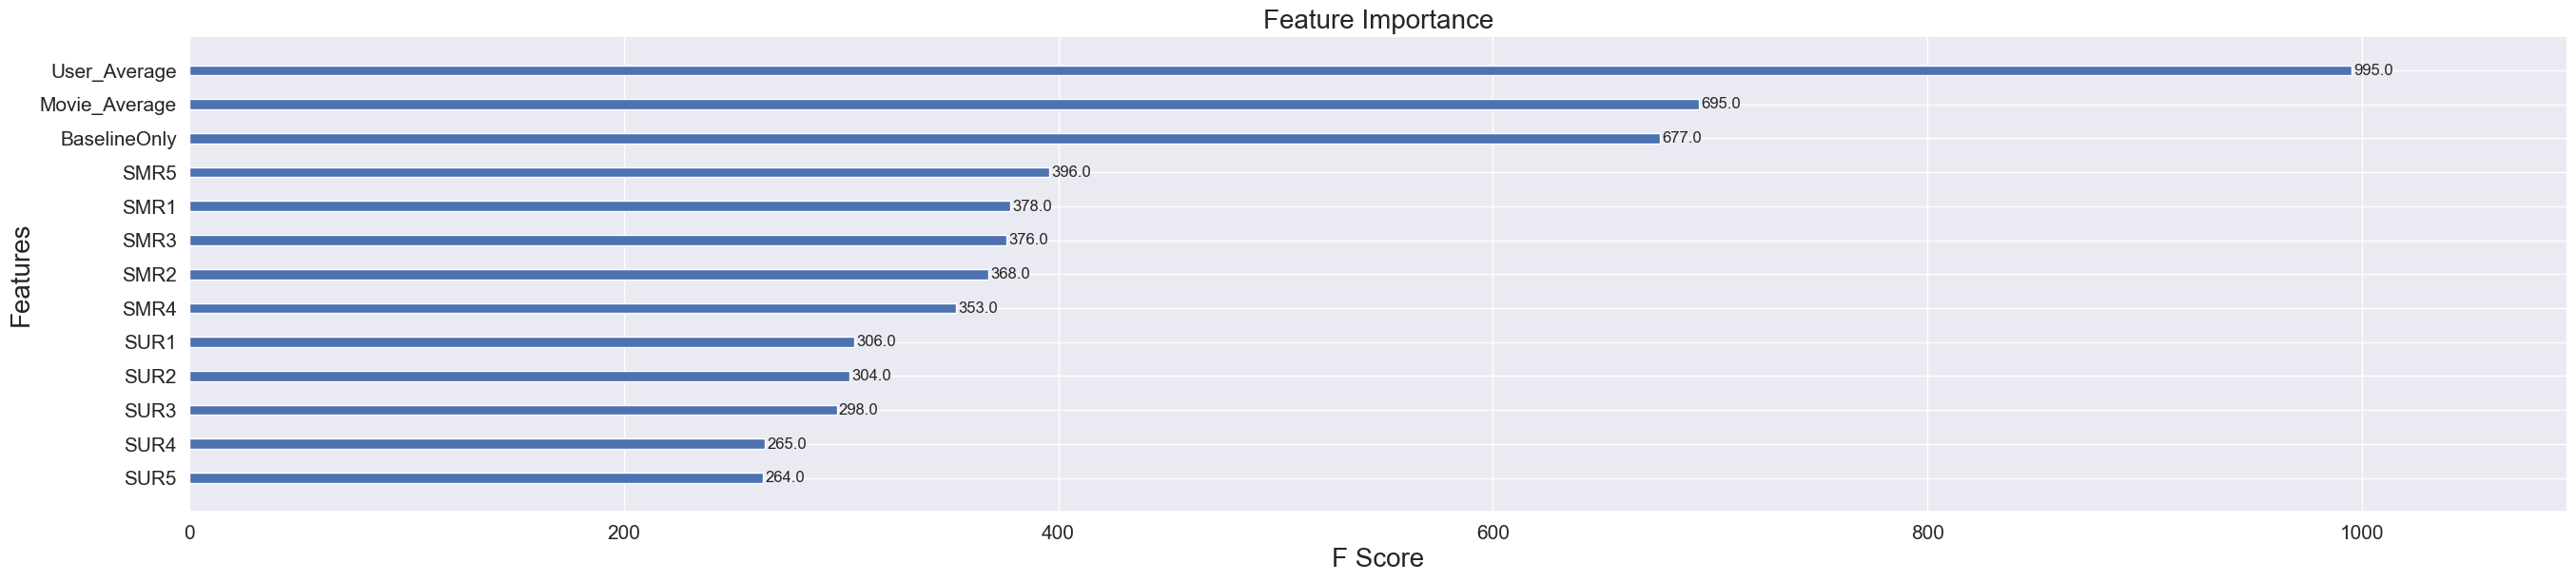

In [115]:
# Fitting the Xgboost again with new BaselineOnly feature

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL")

model_train_evaluation["XGB_BSL"] = train_result
model_test_evaluation["XGB_BSL"] = test_result

Observations:

La caractéristique "BaselineOnly" n'est pas non plus une caractéristique importante.

# **KNN-Baseline**

**KNN-Baseline with User-User Similarity**

In [116]:
# Finding the suitable parameter for Surprise KNN-Baseline with User-User Similarity

param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [True], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}
gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [117]:
# Applying the KNN-Baseline with the searched parameters

sim_options = {'name':'pearson_baseline', 'user_based':True, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'}

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_User")

model_train_evaluation["KNNBaseline_User"] = train_result
model_test_evaluation["KNNBaseline_User"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.3345163322170381
MAPE = 10.189871748001222
--------------------------------------------------
TEST DATA
RMSE = 0.9994800764000862
MAPE = 36.4607597007297
--------------------------------------------------
Time Taken = 0:01:06.161679


Les résultats de l'application du modèle KNNBaseline User-User Similarity montrent une bonne performance sur les données d'entraînement, avec un RMSE de 0.3345 et un MAPE de 10.19%, indiquant des prédictions relativement précises. Cependant, sur les données de test, les résultats sont moins bons, avec un RMSE de 0.9995 et un MAPE de 36.46%, ce qui suggère un problème de sur-apprentissage, où le modèle est trop ajusté aux données d'entraînement et peine à généraliser sur les nouvelles données. Cela pourrait être dû à un mauvais choix de la valeur de k, un surajustement des paramètres, ou un manque de régularisation. Des ajustements dans ces paramètres pourraient aider à améliorer la généralisation du modèle sur les données de test.

**KNN-Baseline with Item-Item Similarity**

In [118]:
# Similarly finding best parameters for Surprise KNN-Baseline with Item-Item Similarity

param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [False], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [119]:
# Applying KNN-Baseline with best parameters searched

sim_options = {'name':'pearson_baseline', 'user_based':False, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'}

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_Item")

model_train_evaluation["KNNBaseline_Item"] = train_result
model_test_evaluation["KNNBaseline_Item"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.2729372731256783
MAPE = 7.949693757355172
--------------------------------------------------
TEST DATA
RMSE = 0.9994800764000862
MAPE = 36.4607597007297
--------------------------------------------------
Time Taken = 0:00:06.928001


Avec l'application du modèle KNNBaseline en mode "item-based", les résultats sur les données d'entraînement se sont améliorés par rapport à la version "user-based", avec un RMSE de 0.2729 et un MAPE de 7.95%, montrant une meilleure précision des prédictions. Cependant, les résultats sur les données de test restent inchangés, avec un RMSE de 0.9995 et un MAPE de 36.46%, suggérant que le modèle souffre toujours de sur-apprentissage et peine à généraliser sur de nouvelles données. Bien que l'approche "item-based" ait amélioré la performance sur l'entraînement, il semble que les paramètres actuels ne soient pas encore optimaux pour éviter l'overfitting. Des ajustements supplémentaires des paramètres ou des méthodes de régularisation pourraient être nécessaires pour améliorer la généralisation du modèle.

In [120]:
# Addding the KNNBaseline features to the train and test dataset

train_regression_data["KNNBaseline_User"] = model_train_evaluation["KNNBaseline_User"]["Prediction"]
train_regression_data["KNNBaseline_Item"] = model_train_evaluation["KNNBaseline_Item"]["Prediction"]

test_regression_data["KNNBaseline_User"] = model_test_evaluation["KNNBaseline_User"]["Prediction"]
test_regression_data["KNNBaseline_Item"] = model_test_evaluation["KNNBaseline_Item"]["Prediction"]

In [121]:
train_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item
0,34,140,3.5,4.0,3.525107,4.0,3.0,4.0,5.0,4.0,4.0,5.0,3.0,5.0,3.0,4.0,4.017986,3.963135,4.010442
1,34,185,3.5,4.0,2.967161,5.0,4.0,3.0,4.0,3.0,5.0,5.0,4.0,4.0,4.0,3.0,3.515016,3.140596,3.055667
2,34,207,3.5,4.0,2.831174,4.0,4.0,3.0,3.0,4.0,5.0,4.0,3.0,3.0,4.0,5.0,3.483033,4.423393,4.864125
3,34,287,3.5,4.0,3.358491,5.0,4.0,4.0,3.0,1.0,3.0,5.0,4.0,3.0,4.0,4.0,3.887365,3.878831,3.908286
4,34,491,3.5,4.0,3.387127,5.0,5.0,5.0,2.0,3.0,4.0,4.0,5.0,3.0,5.0,4.0,4.058829,3.951408,4.115291


In [122]:
test_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item
0,133,1235,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.5,3.496708,3.496708,3.496708
1,133,5891,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.0,3.496708,3.496708,3.496708
2,133,8102,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,5.0,3.496708,3.496708,3.496708
3,133,19090,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.0,3.496708,3.496708,3.496708
4,285,17284,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,5.0,3.496708,3.496708,3.496708


--------------------------------------------------
TRAIN DATA
RMSE : 0.12183314156298834
MAPE : 2.8186556160932876
--------------------------------------------------
TEST DATA
RMSE : 0.9996370380165323
MAPE : 36.45305450216557
--------------------------------------------------
Time Taken :  0:00:00.791847


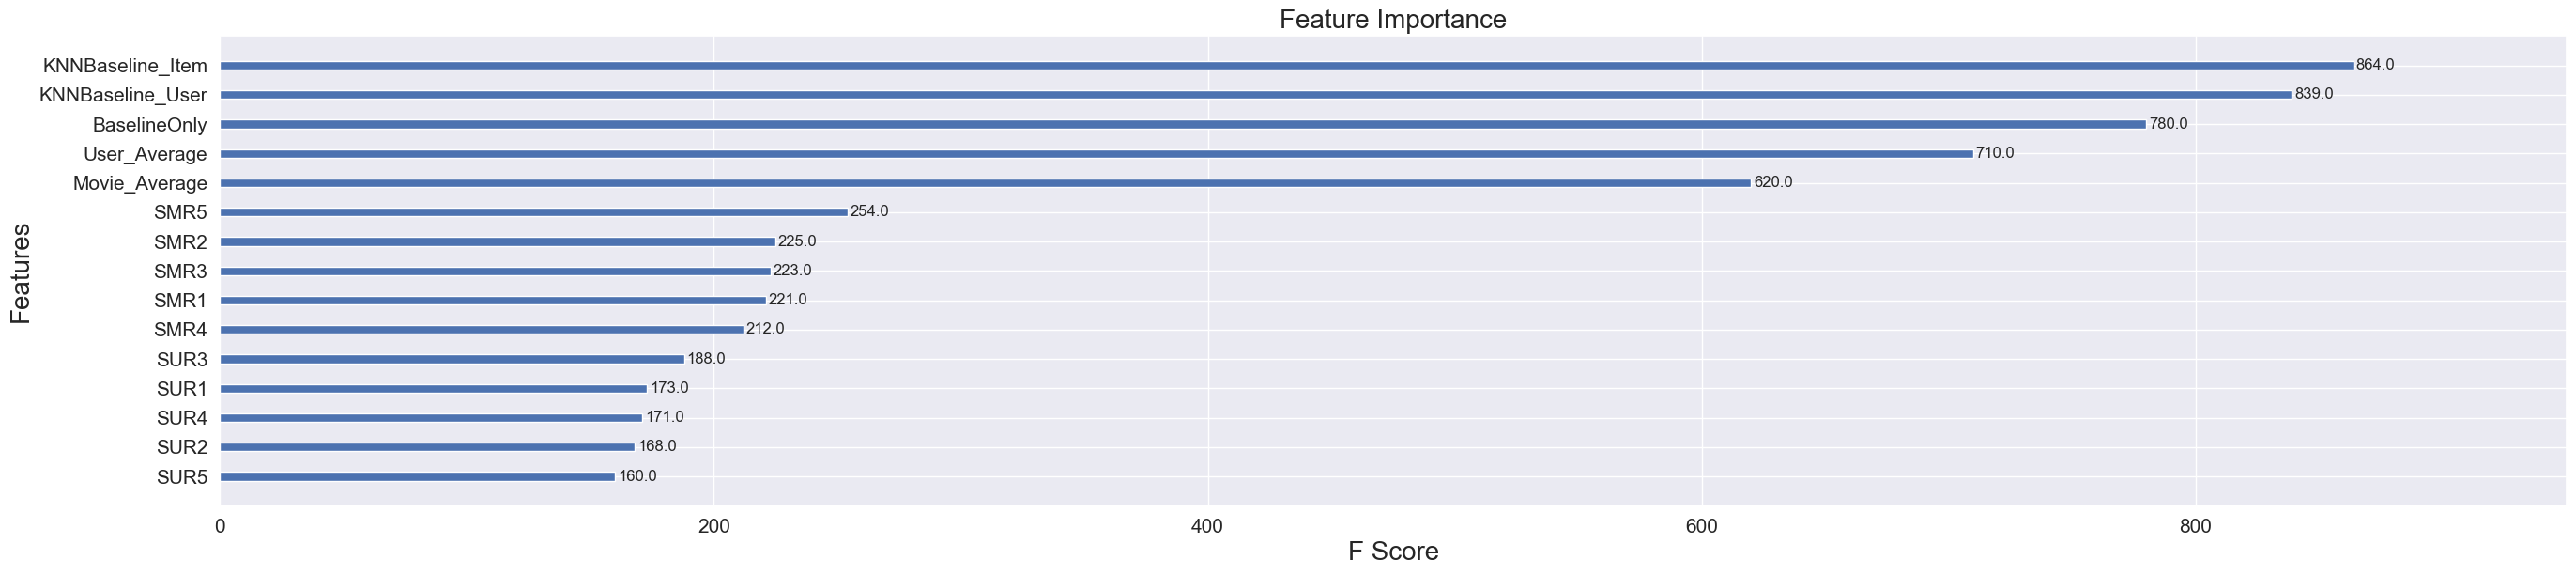

In [123]:
# Applying Xgboost with the KNN-Baseline newly added features

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN")

model_train_evaluation["XGB_BSL_KNN"] = train_result
model_test_evaluation["XGB_BSL_KNN"] = test_result

Observations:

Les caractéristiques KNN Baseline ne sont également pas un prédicteur efficace..

# **SlopeOne**

In [127]:
# Appling the SlopeOne algorithm from the Surprise library

so = SlopeOne()

train_result, test_result = run_surprise(so, trainset, testset, "SlopeOne")

model_train_evaluation["SlopeOne"] = train_result
model_test_evaluation["SlopeOne"] = test_result

--------------------------------------------------
TRAIN DATA
RMSE = 0.7605719565534241
MAPE = 24.411323730221813
--------------------------------------------------
TEST DATA
RMSE = 0.9991458413459061
MAPE = 36.447592340762306
--------------------------------------------------
Time Taken = 0:00:02.908112


L'application de l'algorithme SlopeOne a donné des résultats avec un RMSE de 0.7606 et un MAPE de 24.41% sur les données d'entraînement, ce qui est relativement moins précis par rapport aux autres modèles précédents. Sur les données de test, le RMSE est de 0.9991 et le MAPE de 36.45%, indiquant une mauvaise généralisation, similaire aux autres modèles. Cela suggère que le modèle souffre également de sur-apprentissage, offrant de bonnes performances sur l'entraînement mais des prédictions moins fiables sur les nouvelles données. Des ajustements de paramètres ou l'exploration d'autres modèles pourraient être nécessaires pour améliorer la capacité de généralisation.

In [128]:
# Adding the SlopOne predictions to the train and test datasets

train_regression_data["SlopeOne"] = model_train_evaluation["SlopeOne"]["Prediction"]
train_regression_data["SlopeOne"] = model_train_evaluation["SlopeOne"]["Prediction"]

test_regression_data["SlopeOne"] = model_test_evaluation["SlopeOne"]["Prediction"]
test_regression_data["SlopeOne"] = model_test_evaluation["SlopeOne"]["Prediction"]

# **SVDpp**

In [129]:
# Matrix Factorization SVDpp with implicit feedback

# Hyper-parameter optimization for SVDpp
param_grid = {'n_factors': [10, 30, 50, 80, 100], 'lr_all': [0.002, 0.006, 0.018, 0.054, 0.10]}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8948504079535398
{'n_factors': 10, 'lr_all': 0.006}


le résultat de l'optimisation des hyperparamètres pour l'algorithme SVDpp avec rétroaction implicite montre un meilleur score RMSE de 0.8972. La combinaison des paramètres qui a donné ce meilleur score est la suivante : n_factors = 10 et lr_all = 0.006. Cela signifie que l'algorithme fonctionne le mieux avec un nombre de facteurs latents égal à 10 et un taux d'apprentissage global de 0.006, en produisant des prédictions plus précises avec cette configuration.

In [130]:
#Applying SVDpp with best parameters¶

algo = SVDpp(n_factors = gs.best_params['rmse']['n_factors'], lr_all = gs.best_params['rmse']["lr_all"], verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVDpp")

model_train_evaluation["SVDpp"] = train_result
model_test_evaluation["SVDpp"] = test_result

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.7643354311335789
MAPE = 25.423861614780733
--------------------------------------------------
TEST DATA
RMSE = 0.9995359699108716
MAPE = 36.46111618038728
--------------------------------------------------
Time Taken = 0:00:04.023176


In [131]:
# XGBoost 13 Features + Surprise BaselineOnly + Surprise KNN Baseline + SVDpp

train_regression_data["SVDpp"] = model_train_evaluation["SVDpp"]["Prediction"]
test_regression_data["SVDpp"] = model_test_evaluation["SVDpp"]["Prediction"]

In [132]:
train_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item,SlopeOne,SVDpp
0,34,140,3.5,4.0,3.525107,4.0,3.0,4.0,5.0,4.0,4.0,5.0,3.0,5.0,3.0,4.0,4.017986,3.963135,4.010442,4.220130,4.146854
1,34,185,3.5,4.0,2.967161,5.0,4.0,3.0,4.0,3.0,5.0,5.0,4.0,4.0,4.0,3.0,3.515016,3.140596,3.055667,3.718481,3.438215
2,34,207,3.5,4.0,2.831174,4.0,4.0,3.0,3.0,4.0,5.0,4.0,3.0,3.0,4.0,5.0,3.483033,4.423393,4.864125,3.561952,3.691542
3,34,287,3.5,4.0,3.358491,5.0,4.0,4.0,3.0,1.0,3.0,5.0,4.0,3.0,4.0,4.0,3.887365,3.878831,3.908286,3.892439,3.765428
4,34,491,3.5,4.0,3.387127,5.0,5.0,5.0,2.0,3.0,4.0,4.0,5.0,3.0,5.0,4.0,4.058829,3.951408,4.115291,4.100594,4.059171


In [133]:
test_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item,SlopeOne,SVDpp
0,133,1235,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.5,3.496708,3.496708,3.496708,3.496708,3.496708
1,133,5891,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.0,3.496708,3.496708,3.496708,3.496708,3.496708
2,133,8102,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,5.0,3.496708,3.496708,3.496708,3.496708,3.496708
3,133,19090,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.0,3.496708,3.496708,3.496708,3.496708,3.496708
4,285,17284,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,5.0,3.496708,3.496708,3.496708,3.496708,3.496708


--------------------------------------------------
TRAIN DATA
RMSE : 0.11508592670486385
MAPE : 2.6653623439899796
--------------------------------------------------
TEST DATA
RMSE : 0.9991745672623495
MAPE : 36.44781614131314
--------------------------------------------------
Time Taken :  0:00:00.523419


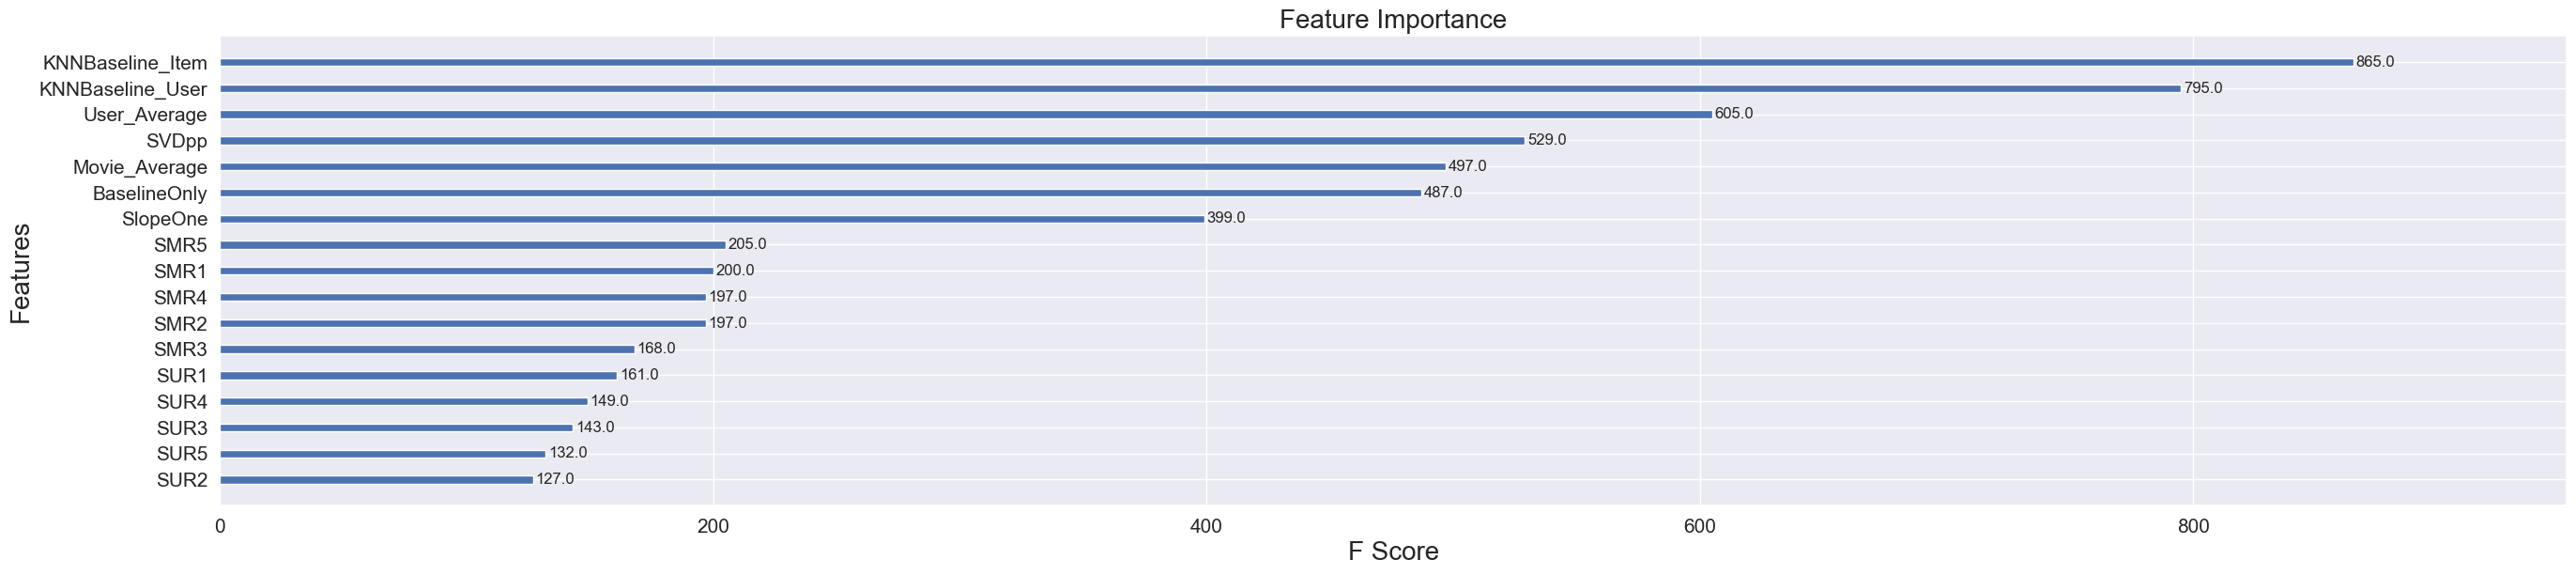

In [134]:
# Applying Xgboost on the feature set

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN_MF")

model_train_evaluation["XGB_BSL_KNN_MF"] = train_result
model_test_evaluation["XGB_BSL_KNN_MF"] = test_result

--------------------------------------------------
TRAIN DATA
RMSE : 0.12765559905919788
MAPE : 2.9837251541305867
--------------------------------------------------
TEST DATA
RMSE : 0.9984849956721006
MAPE : 36.52369408660073
--------------------------------------------------
Time Taken :  0:00:00.559103


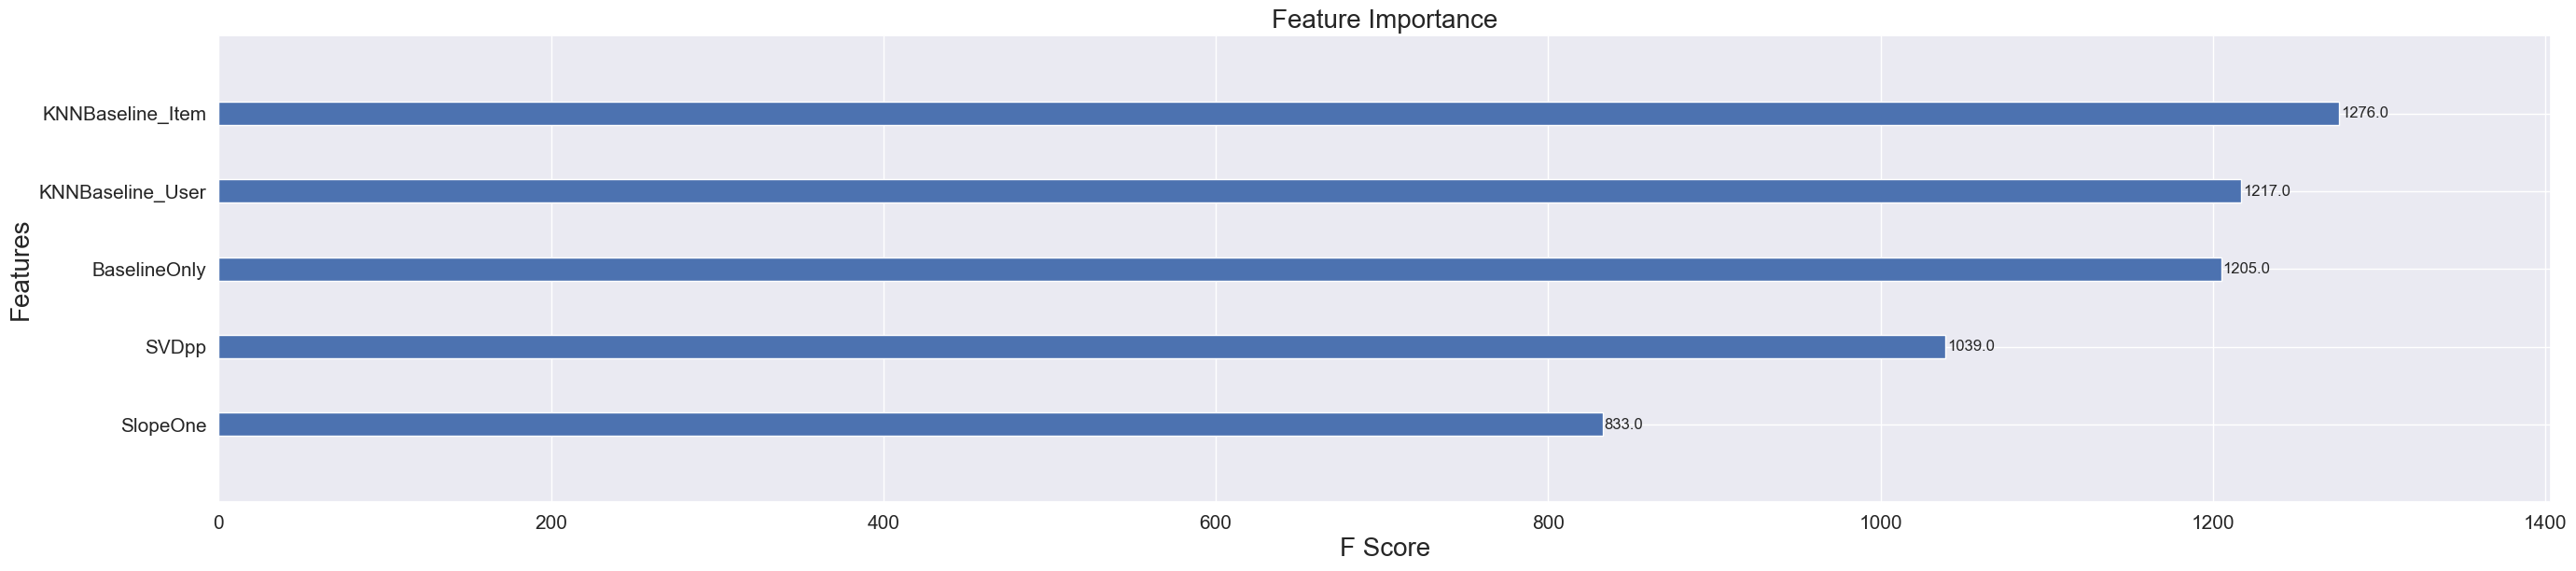

In [135]:
# Applying Xgboost with Surprise's BaselineOnly + KNN Baseline + SVD + SVDpp + SlopeOne

x_train = train_regression_data[["BaselineOnly", "KNNBaseline_User", "KNNBaseline_Item", "SVDpp", "SlopeOne"]]
x_test = test_regression_data[["BaselineOnly", "KNNBaseline_User", "KNNBaseline_Item", "SVDpp", "SlopeOne"]]

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_KNN_MF_SO")

model_train_evaluation["XGB_KNN_MF_SO"] = train_result
model_test_evaluation["XGB_KNN_MF_SO"] = test_result

Observations :  

BaselineOnly et KNNBaseline (User et Item) semblent être les estimateurs les plus influents pour prédire les notes.

SVDpp joue également un rôle clé dans l’amélioration des prédictions.

SlopeOne apporte une contribution notable, mais avec une importance moindre par rapport aux autres estimateurs


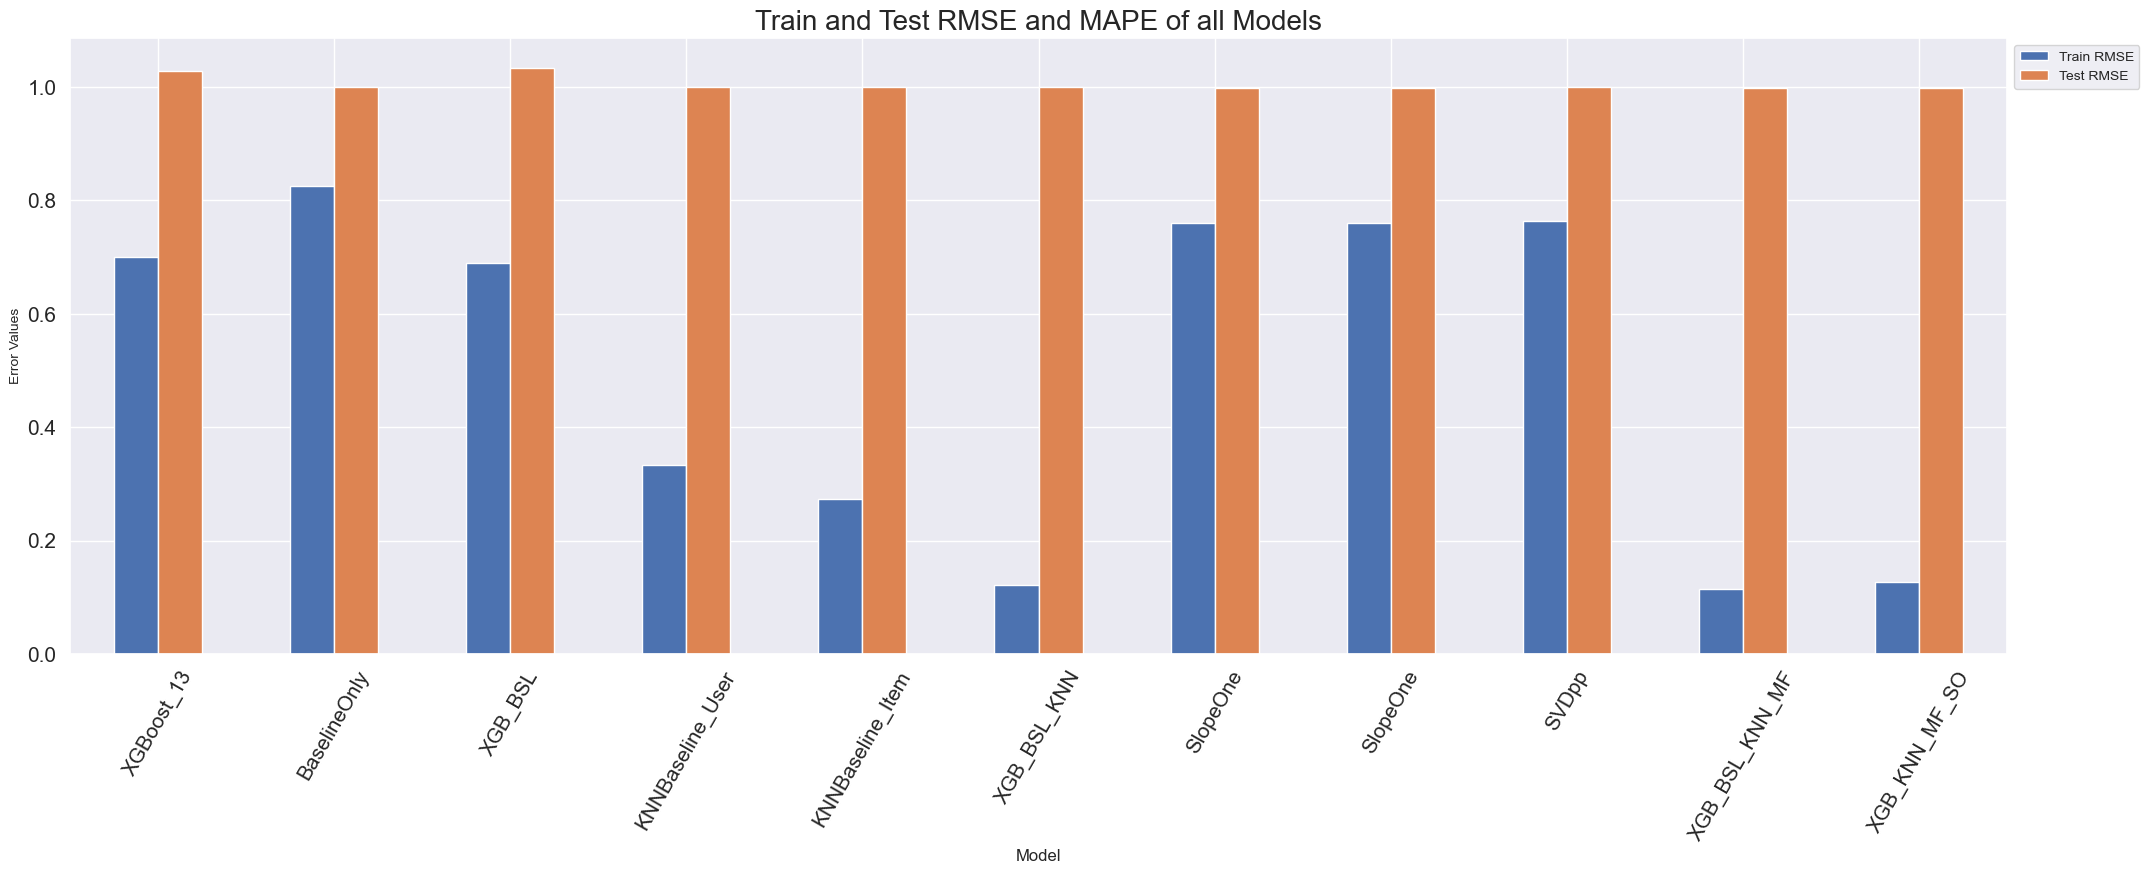

In [136]:
# Visualizing the errors of all the models we tested out

error_table2 = error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)
error_table2.plot(x = "Model", kind = "bar", figsize = (25, 8), grid = True, fontsize = 15)
plt.title("Train and Test RMSE and MAPE of all Models", fontsize = 20)
plt.ylabel("Error Values", fontsize = 10)
plt.xticks(rotation=60)
plt.legend(bbox_to_anchor=(1, 1), fontsize = 10)
plt.show()

In [137]:
# Tabular Values of Errors

error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)

,Model,Train RMSE,Test RMSE
0,XGBoost_13,0.700831,1.027542
1,BaselineOnly,0.825905,0.999579
2,XGB_BSL,0.689020,1.034284
3,KNNBaseline_User,0.334516,0.999480
4,KNNBaseline_Item,0.272937,0.999480
5,XGB_BSL_KNN,0.121833,0.999637
6,SlopeOne,0.760572,0.999146
7,SlopeOne,0.760572,0.999146
8,SVDpp,0.764335,0.999536
9,XGB_BSL_KNN_MF,0.115086,0.999175


Observations:  

Tous les algorithmes semblent très performants, avec des différences restant très proches les unes des autres.

On peut observer qu'en utilisant plusieurs algorithmes de prédiction de notation ensemble et en les empilant, puis en utilisant un algorithme final, cela semble aboutir au Testing RMSE le plus bas. Par exemple : BaselineOnly de Surprise + KNN Baseline + SVDpp + SlopeOne ensemble avec XGBoost.

SlopeOne semble avoir le Testing RMSE le plus bas parmi tous les autres algorithmes.

SVDpp est un algorithme montre un Testing RMSE plus bas parmi les autres prédicteurs, sauf SlopeOne


### **4.3 Generating Recommendation for Users**

Nous utilisons SVDpp pour générer au maximum 10 films recommandés pour divers utilisateurs.

In [138]:
# Testing the recommendations made by SVDpp Algorithm

from collections import defaultdict

def Get_top_n(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, mid, true_r, est, _ in predictions:
        top_n[uid].append((mid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [139]:
# Creating instance of svd_pp

svd_pp = SVDpp(n_factors = 10, lr_all = 0.006, verbose=True)
svd_pp.fit(trainset)
predictions = svd_pp.test(testset)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19


In [140]:
# Saving the training predictions

train_pred = svd_pp.test(trainset.build_anti_testset())
top_n = Get_top_n(train_pred, n=10)

In [141]:
# Print the recommended items for each user

def Generate_Recommendated_Movies(u_id, n=10):

    recommend = pd.DataFrame(top_n[u_id], columns=["Movie_Id", "Predicted_Rating"])
    recommend = recommend.merge(movies, how="inner", left_on="Movie_Id", right_on="movieId")
    recommend = recommend[["Movie_Id", "title", "genres", "Predicted_Rating"]]

    return recommend[:n]

In [142]:
# Saving the sampled user id list to help generate movies

sampled_user_id = list(top_n.keys())

In [143]:
# Generating recommendation using the user_Id

test_id = random.choice(sampled_user_id)
print("The user Id is : ", test_id)
Generate_Recommendated_Movies(test_id)

The user Id is :  49779


,Movie_Id,title,genres,Predicted_Rating
0,5918,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,4.441631
1,2850,"Lady Eve, The (1941)",Comedy|Romance,4.369509
2,213,Before the Rain (Pred dozhdot) (1994),Drama|War,4.321289
3,1208,"Sting, The (1973)",Comedy|Crime,4.274467
4,3380,"Hustler, The (1961)",Drama,4.266203
5,1733,Fireworks (Hana-bi) (1997),Crime|Drama,4.254510
6,2120,Shadow of a Doubt (1943),Crime|Drama|Thriller,4.245105
7,7045,Fog of War: Eleven Lessons from the Life of Ro...,Documentary|War,4.238024
8,1172,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,4.221604
9,3179,Hard-Boiled (Lat sau san taam) (1992),Action|Crime|Drama|Thriller,4.168919


In [ ]:
# Generating recommendation using the user_Id

test_id = random.choice(sampled_user_id)
print("The user Id is : ", test_id)
Generate_Recommendated_Movies(test_id)

The user Id is :  13514


,Movie_Id,title,genres,Predicted_Rating
0,316,"Shawshank Redemption, The (1994)",Crime|Drama,4.303549
1,213,Before the Rain (Pred dozhdot) (1994),Drama|War,4.280302
2,2850,"Lady Eve, The (1941)",Comedy|Romance,4.224732
3,5918,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,4.209128
4,3380,"Hustler, The (1961)",Drama,4.108861
5,1733,Fireworks (Hana-bi) (1997),Crime|Drama,4.100823
6,7045,Fog of War: Eleven Lessons from the Life of Ro...,Documentary|War,4.092413
7,1184,Once Upon a Time in the West (C'era una volta ...,Action|Drama|Western,4.071094
8,2120,Shadow of a Doubt (1943),Crime|Drama|Thriller,4.062668
9,9696,"Downfall (Untergang, Der) (2004)",Drama|War,4.059000


In [144]:
# Generating recommendation using the user_Id

test_id = random.choice(sampled_user_id)
print("The user Id is : ", test_id)
Generate_Recommendated_Movies(test_id)

The user Id is :  2621


,Movie_Id,title,genres,Predicted_Rating
0,5918,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,4.704397
1,316,"Shawshank Redemption, The (1994)",Crime|Drama,4.636005
2,213,Before the Rain (Pred dozhdot) (1994),Drama|War,4.616164
3,2850,"Lady Eve, The (1941)",Comedy|Romance,4.552587
4,7045,Fog of War: Eleven Lessons from the Life of Ro...,Documentary|War,4.502522
5,3179,Hard-Boiled (Lat sau san taam) (1992),Action|Crime|Drama|Thriller,4.474645
6,1733,Fireworks (Hana-bi) (1997),Crime|Drama,4.471966
7,9696,"Downfall (Untergang, Der) (2004)",Drama|War,4.471402
8,1184,Once Upon a Time in the West (C'era una volta ...,Action|Drama|Western,4.463177
9,4913,Witness for the Prosecution (1957),Drama|Mystery|Thriller,4.453293


In [ ]:
# Generating recommendation using the user_Id

test_id = random.choice(sampled_user_id)
print("The user Id is : ", test_id)
Generate_Recommendated_Movies(test_id)

The user Id is :  47133


,Movie_Id,title,genres,Predicted_Rating
0,213,Before the Rain (Pred dozhdot) (1994),Drama|War,4.525050
1,2850,"Lady Eve, The (1941)",Comedy|Romance,4.476013
2,5918,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,4.378274
3,3380,"Hustler, The (1961)",Drama,4.363563
4,4913,Witness for the Prosecution (1957),Drama|Mystery|Thriller,4.356607
5,1733,Fireworks (Hana-bi) (1997),Crime|Drama,4.333344
6,3179,Hard-Boiled (Lat sau san taam) (1992),Action|Crime|Drama|Thriller,4.326098
7,531,Shadowlands (1993),Drama|Romance,4.292230
8,7045,Fog of War: Eleven Lessons from the Life of Ro...,Documentary|War,4.286349
9,3005,Kagemusha (1980),Drama|War,4.277592


## **5. Conclusion**

Dans ce projet, nous avons appris l'importance des systèmes de recommandation, les types de systèmes de recommandation mis en œuvre, et comment utiliser la factorisation de matrices pour améliorer un système.

Nous avons ensuite construit un système de recommandation de films qui prend en compte la similarité utilisateur-utilisateur, la similarité film-film, les moyennes globales et la factorisation de matrices. Ces concepts peuvent être appliqués à tout autre système d'interaction utilisateur-élément.

Nous avons essayé de générer des recommandations basées sur la matrice de similarité et les techniques de Filtrage Collaboratif.

Nous avons essayé de prédire les notes que l'utilisateur pourrait donner aux films en fonction de son comportement passé en matière de notations, puis mesuré la précision à l'aide des métriques d'erreur RMSE et MAPE.

Il y a assurément une grande marge d'amélioration et d'expérimentation avec différentes techniques et algorithmes ML/DL.